In [1]:
cd '/Users/jbud/Desktop/Galvanize/repos/Covid-19-Forecasting'

/Users/jbud/Desktop/Galvanize/repos/Covid-19-Forecasting


In [5]:
matplotlib.rcParams.update({'font.size': 16})
plt.style.use('fivethirtyeight')
plt.close('all')

In [4]:
# %load src/main.py
'''
See notebooks/EDA.ipynb for plots

Import scripts from other .py files
'''
from src.State_Comparison import Comparable_States, Combined_State_Analysis, state_analysis, Predictions
from src.reg_model_class import reg_model
from src.data_clean_script import replace_initial_values, replace_with_moving_averages, load_and_clean_data, create_spline, convert_to_date, fill_na_with_surround, convert_to_moving_avg_df
from src.Misc_functions import series_to_supervised, generate_prediction_df, normalize_days, plot_normalized

import pandas as pd
import numpy as np
import datetime

from scipy.interpolate import make_interp_spline

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap
matplotlib.rcParams.update({'font.size': 16})
plt.style.use('fivethirtyeight')
plt.close('all')

def state_plot(states, df):
    '''
    Plots data from a list of states into one figure.
        Parameters:
            states(list of strings)
            df (Pandas DataFrame where information to plot is)
        Returns:
            plot (fig)
    '''
    fig, ax = plt.subplots(1, 1, figsize=(14, 7))
    for state in states:
        query = df[df['state'] == state]
        x = query['days_elapsed'].apply(convert_to_date).values
        y = query['New_Cases_per_pop'].values
        ax.plot(x, y, label = state)
        ax.set_xlabel('Date')
        ax.set_ylabel('New Daily Cases Per 1M Pop')
        ax.set_title('Daily New Cases Per State Over Time')
        ax.legend()
    fig.show()

if __name__ == '__main__':
    #Specify state to draw predictions for below, and similar state finding parameters
    #Similar_States.master_pop_density_df[Similar_States.master_pop_density_df['Recovery Factor'] < 1.1]
    state = 'North Carolina'
    min_recovery_factor = 1.2
    pop_density_tolerance = 20
    SD_delay = 7
    train_test_split = 0.4
    test_row_start = 35
    normalize_days = True
    #Define outbreak start
    percent_max_cases = 0.25

    raw_covid_df = load_and_clean_data(use_internet = True)
    covid_df = convert_to_moving_avg_df(raw_covid_df, SD_delay = SD_delay)
    Similar_States = Comparable_States(covid_df)
    sim_states_df = Similar_States.get_similar_states(
        state_to_predict=state, recovery_factor_min=min_recovery_factor, pop_density_tolerance = pop_density_tolerance)
    similar_states = sim_states_df.index.values
    
    if len(similar_states) == 0:
        print('No similar states found. Try to expand recovery_factor_min and pop_density_tolerance.')
    else:
        print("The Most similar states to {} that meet the comparable parameters are: {}. These will be used to predict for {}.".format(
            state, similar_states, state))
        State_Compile = Combined_State_Analysis(covid_df, state, similar_states, train_test_split=train_test_split, min_days=0, print_err=True, normalize_day=normalize_days, percent_of_max_cases = percent_max_cases)

        normalized_df = State_Compile.X_norm.copy()
        normalized_df['New_Cases_per_pop'] = State_Compile.y_norm
        
        feat_importances = State_Compile.get_feature_importances()
        print(feat_importances)
        Prediction_Insights = Predictions(covid_df, state, similar_states, State_Compile)
        Prediction_Insights.plot_similar_states(save = None)
        plot_normalized(normalized_df, State_Compile, save = None)
        Prediction_Insights.plot_pred_vs_actual(row_start = test_row_start, save = None)
        Prediction_Insights.forecast_to_future(SD_delay = SD_delay, save = None)
    #Plots in notebooks/EDA.ipynb


The Most similar states to North Carolina that meet the comparable parameters are: ['Virginia' 'Hawaii' 'Illinois']. These will be used to predict for North Carolina.
Train/Test Split on day 31 after state reached 25.0 % of maximum daily new cases.
rmse: 41.34352112308632
                                 0
parks(t)                  0.011623
workplaces(t)             0.002365
retail_and_recreation(t)  0.002163
residential(t)            0.001228
driving(t)                0.001168
days_elapsed(t)           0.000758
pop_density(t)            0.000696
grocery_and_pharmacy(t)   0.000691
transit_stations(t)       0.000607


<Figure size 1400x700 with 1 Axes>

/Users/jbud/Desktop/Galvanize/repos/Covid-19-Forecasting/src/Misc_functions.py:236: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 1200x600 with 1 Axes>

<Figure size 1400x700 with 1 Axes>

<Figure size 1400x700 with 1 Axes>

In [16]:
def run_model(state, min_recovery_factor = 1.2, pop_density_tolerance = 20, SD_delay = 7, train_test_split =0.4, percent_max_cases = 0.25, test_row_start = 35):
    #Specify state to draw predictions for below, and similar state finding parameters
    #Similar_States.master_pop_density_df[Similar_States.master_pop_density_df['Recovery Factor'] < 1.1]
    #Define outbreak start (percent_of_max_cases)
    
    normalize_days = True
    
    raw_covid_df = load_and_clean_data(use_internet = True)
    covid_df = convert_to_moving_avg_df(raw_covid_df, SD_delay = SD_delay)
    Similar_States = Comparable_States(covid_df)
    sim_states_df = Similar_States.get_similar_states(
        state_to_predict=state, recovery_factor_min=min_recovery_factor, pop_density_tolerance = pop_density_tolerance)
    similar_states = sim_states_df.index.values
    
    if len(similar_states) == 0:
        print('No similar states found. Try to expand recovery_factor_min and pop_density_tolerance.')
    else:
        print("The Most similar states to {} that meet the comparable parameters are: {}. These will be used to predict for {}.".format(
            state, similar_states, state))
        State_Compile = Combined_State_Analysis(covid_df, state, similar_states, train_test_split=train_test_split, min_days=0, print_err=True, normalize_day=normalize_days, percent_of_max_cases = percent_max_cases)

        normalized_df = State_Compile.X_norm.copy()
        normalized_df['New_Cases_per_pop'] = State_Compile.y_norm
        

        feat_importances = State_Compile.get_feature_importances()
        print(feat_importances)
        Prediction_Insights = Predictions(covid_df, state, similar_states, State_Compile)
        state_sv = state.replace(' ', '_')
        Prediction_Insights.plot_similar_states(save = 'images/{}similarplots'.format(state_sv))
        plot_normalized(normalized_df, State_Compile, save = 'images/{}normalized'.format(state_sv))
        Prediction_Insights.plot_pred_vs_actual(row_start = 35, save = 'images/{}validity'.format(state_sv))
        Prediction_Insights.forecast_to_future(SD_delay = SD_delay, save = 'images/{}future'.format(state_sv))
    #Plots in notebooks/EDA.ipynb


In [71]:
State_pop_dens_df = Similar_States.master_pop_density_df

In [72]:
State_pop_dens_df

pop_density  Recovery Factor
state                                       
Alaska              1.28628         1.000000
Wyoming             5.84002         1.477477
Montana             7.46677         3.166667
North Dakota       11.03930         2.297521
South Dakota       11.91156         2.045064
New Mexico         17.28503         1.537150
Idaho              22.09692         3.134615
Nebraska           25.41615         2.742438
Nevada             28.59928         1.000000
Kansas             35.59678         3.305310
Utah               39.94298         1.142597
Maine              43.63356         1.579399
Oregon             44.80861         1.000000
Colorado           56.40113         3.377568
Iowa               56.92839         1.728035
Oklahoma           57.65465         1.000000
Arkansas           58.40298         1.000000
Mississippi        63.70565         1.003457
Arizona            64.95496         1.000000
Vermont            68.14159         3.670886
Minnesota          71.59219         1.836864
West Virginia      73.96913         2.463768
Missouri           89.74528         1.106715
Alabama            96.92212         1.000000
Louisiana         107.51745         2.907870
Wisconsin         108.04967         1.713474
Texas             112.82039         1.000000
Kentucky          113.95664         1.287319
Washington        117.32718         1.629819
New Hampshire     153.16050         2.489286
Tennessee         167.27479         1.221676
South Carolina    173.31742         1.000000
Michigan          177.66549         6.138950
Georgia           186.67187         1.125501
Indiana           188.28097         1.957806
North Carolina    218.27023         1.000000
Virginia          218.44029         1.870081
Hawaii            219.94193         3.960000
Illinois          228.02432         3.061200
California        256.37274         1.000000
Pennsylvania      286.54489         3.363401
Ohio              287.50383         2.354768
Florida           410.12559         1.000000
New York          412.52109        13.052642
Delaware          504.30734         4.281250
Maryland          626.67312         2.085245
Connecticut       735.86886         6.559524
Massachusetts     894.43551         7.653999
Rhode Island     1021.43230         5.401186
New Jersey       1215.19908         9.483776

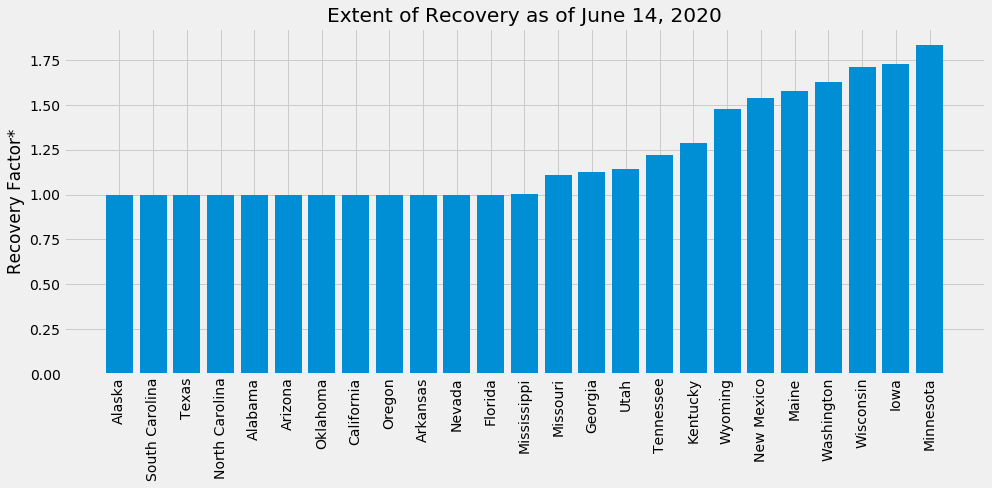

In [95]:
fig, ax = plt.subplots(1,1,figsize = (14, 7))
show_n = 25
sort_recov = State_pop_dens_df.sort_values('Recovery Factor')
ax.bar(sort_recov.index[:show_n], sort_recov['Recovery Factor'][:show_n])
ax.set_xticklabels(labels = sort_recov.index[:show_n],rotation = 90)
ax.set_ylabel('Recovery Factor*')
ax.set_title('Extent of Recovery as of June 14, 2020')
fig.tight_layout()

In [96]:
fig.savefig('images/State_Recovery.png')

The Most similar states to Alaska that meet the comparable parameters are: ['Wyoming' 'Montana' 'North Dakota' 'South Dakota' 'New Mexico' 'Idaho'
 'Nebraska' 'Kansas' 'Utah' 'Maine' 'Colorado' 'Iowa' 'Vermont'
 'Minnesota' 'West Virginia' 'Missouri']. These will be used to predict for Alaska.
Train/Test Split on day 16 after state reached 50.0 % of maximum daily new cases.
rmse: 37.162290526726025
                                 0
residential(t)            0.001323
transit_stations(t)       0.001265
days_elapsed(t)           0.000885
parks(t)                  0.000870
retail_and_recreation(t)  0.000754
grocery_and_pharmacy(t)   0.000611
pop_density(t)            0.000600
workplaces(t)             0.000416
driving(t)                0.000364


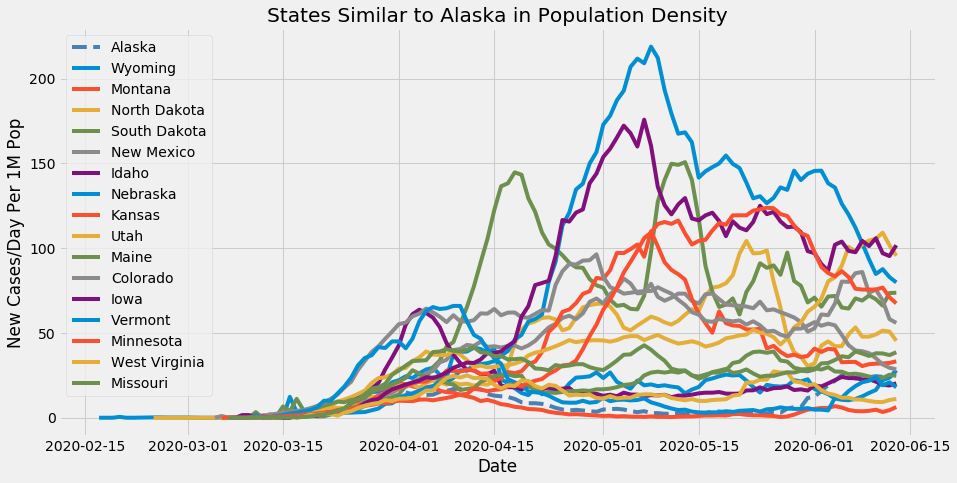

/Users/jbud/Desktop/Galvanize/repos/Covid-19-Forecasting/src/Misc_functions.py:236: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


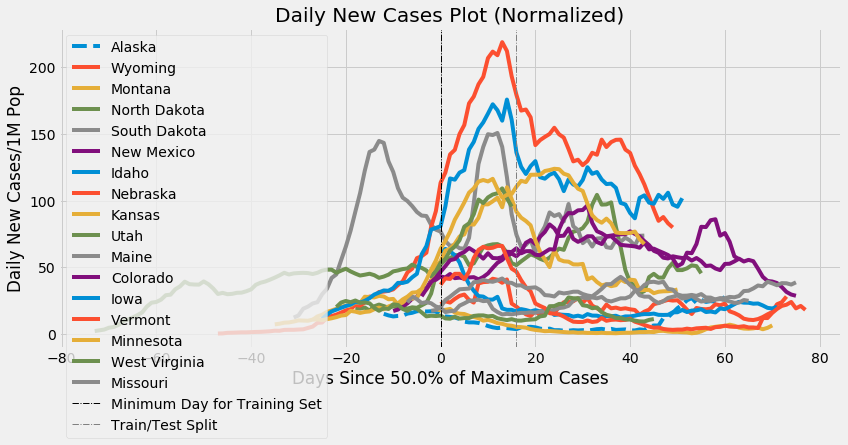

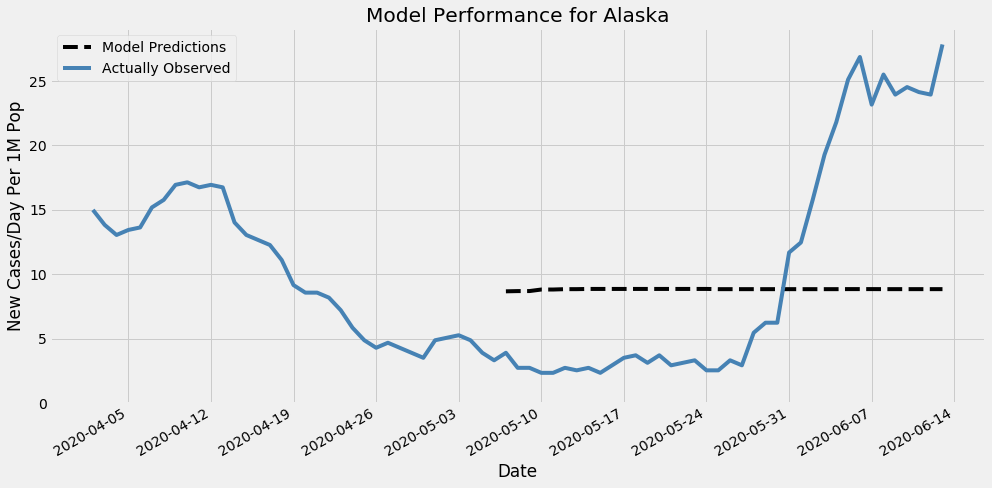

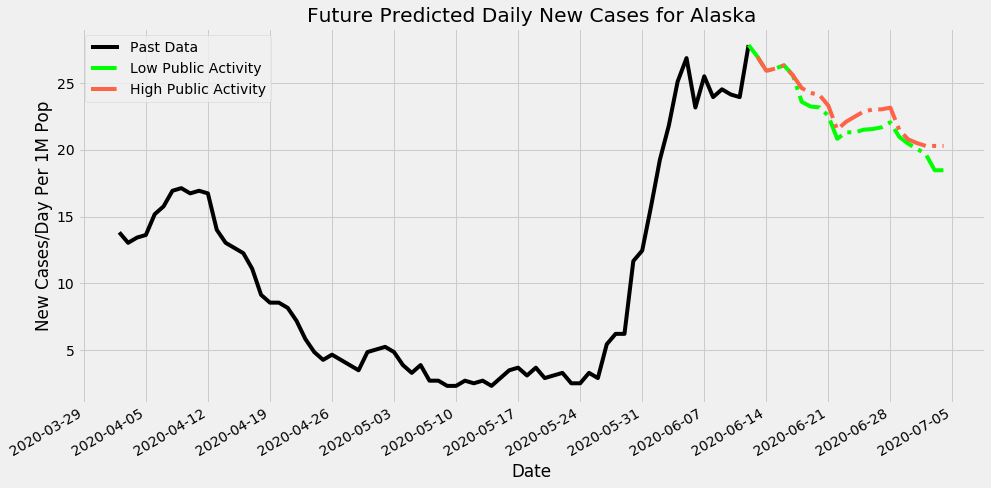

In [42]:
run_model(state = 'Alaska', min_recovery_factor = 1.1, pop_density_tolerance = 100, SD_delay = 5, train_test_split =0.22, percent_max_cases = 0.5, test_row_start = 15)

The Most similar states to Oregon that meet the comparable parameters are: ['Nebraska' 'Kansas' 'Maine' 'Colorado' 'Iowa']. These will be used to predict for Oregon.
Train/Test Split on day 23 after state reached 40.0 % of maximum daily new cases.
rmse: 26.462755436153564
                                 0
grocery_and_pharmacy(t)   0.002992
driving(t)                0.002398
transit_stations(t)       0.001909
workplaces(t)             0.001888
residential(t)            0.001486
parks(t)                  0.001086
days_elapsed(t)           0.000885
retail_and_recreation(t)  0.000469
pop_density(t)            0.000259


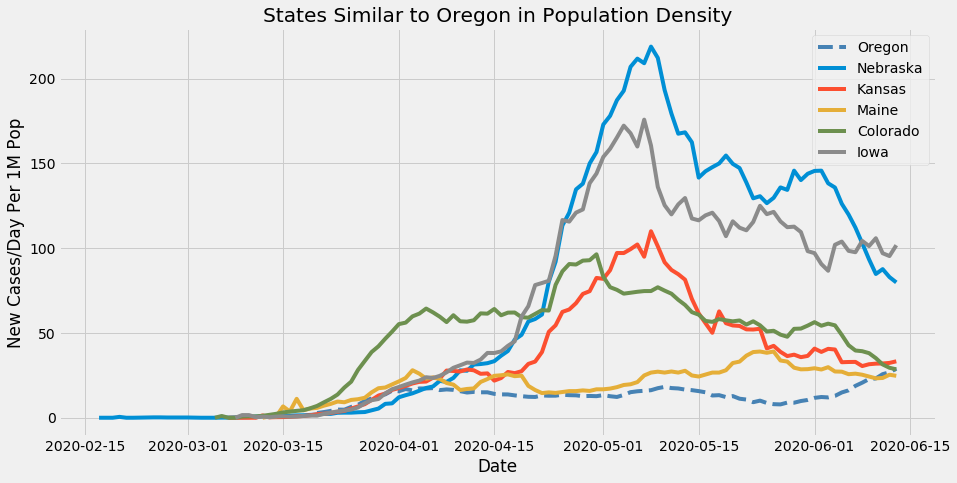

/Users/jbud/Desktop/Galvanize/repos/Covid-19-Forecasting/src/Misc_functions.py:236: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


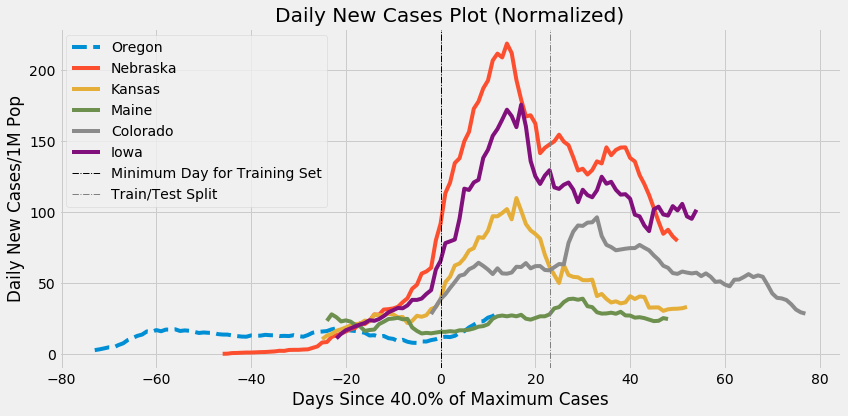

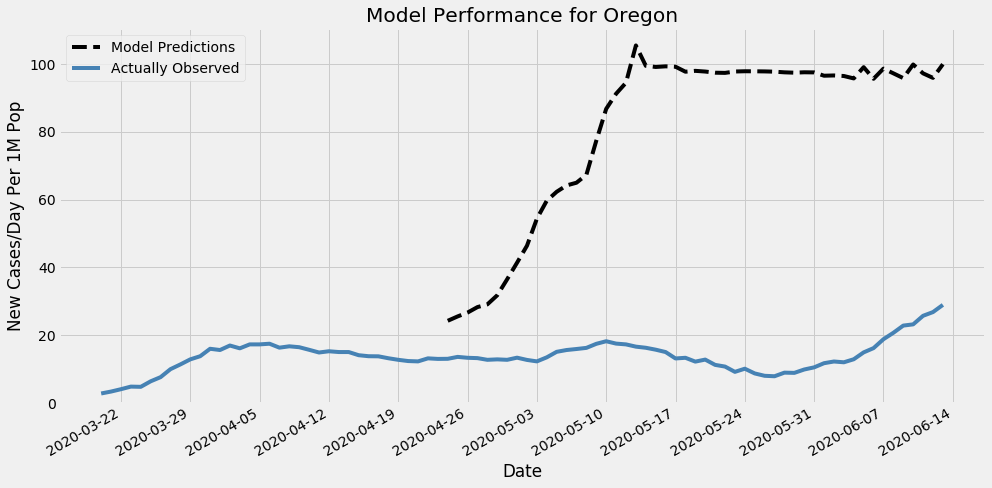

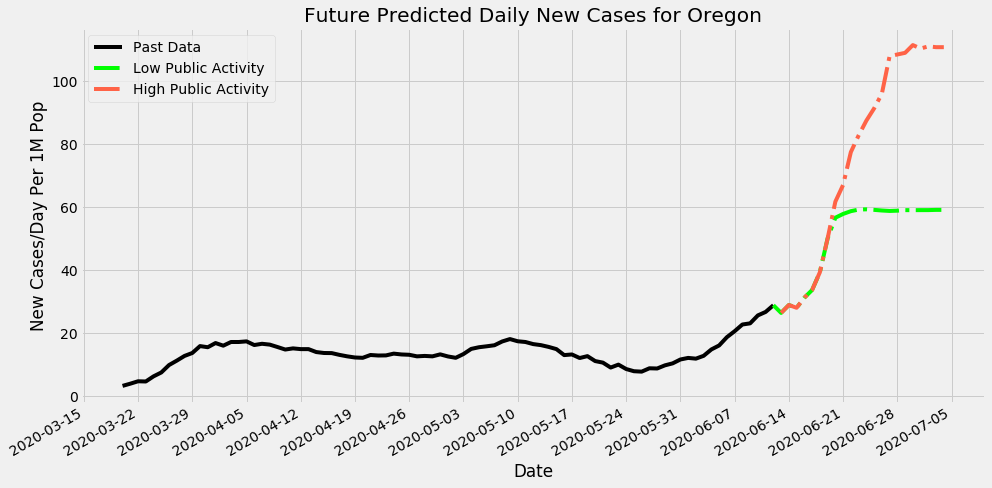

In [281]:
run_model(state = 'Oregon', min_recovery_factor = 1.2, pop_density_tolerance = 20, SD_delay = 7, train_test_split =0.3, percent_max_cases = 0.4)

The Most similar states to Arizona that meet the comparable parameters are: ['Colorado' 'Iowa' 'Mississippi' 'Vermont' 'Minnesota']. These will be used to predict for Arizona.
Train/Test Split on day 19 after state reached 65.0 % of maximum daily new cases.
rmse: 49.438594541920466
                                 0
driving(t)                0.043979
parks(t)                  0.033778
grocery_and_pharmacy(t)   0.012653
retail_and_recreation(t)  0.006943
workplaces(t)             0.004921
residential(t)            0.004323
transit_stations(t)       0.002029
days_elapsed(t)           0.000704
pop_density(t)            0.000016


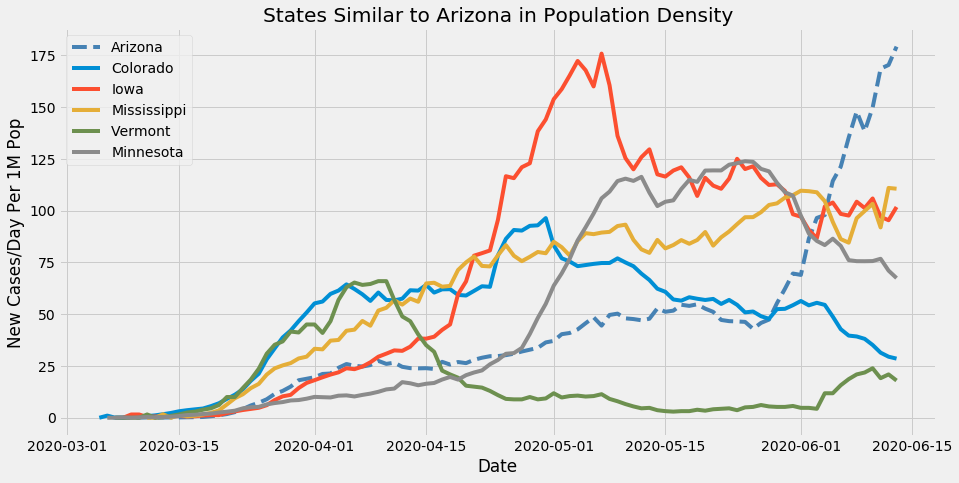

/Users/jbud/Desktop/Galvanize/repos/Covid-19-Forecasting/src/Misc_functions.py:236: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


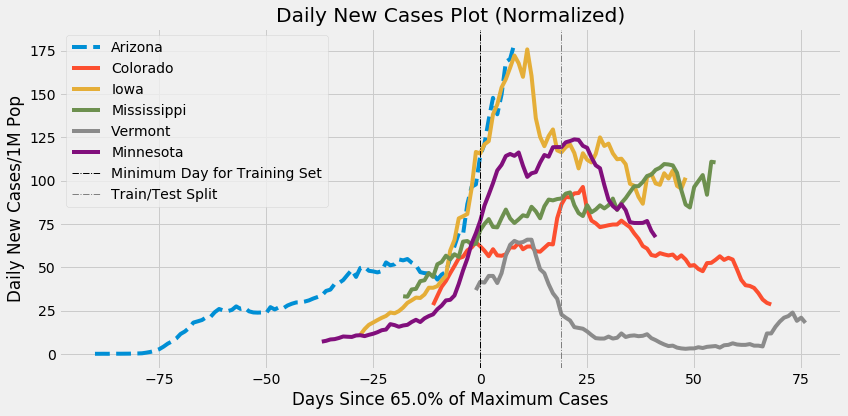

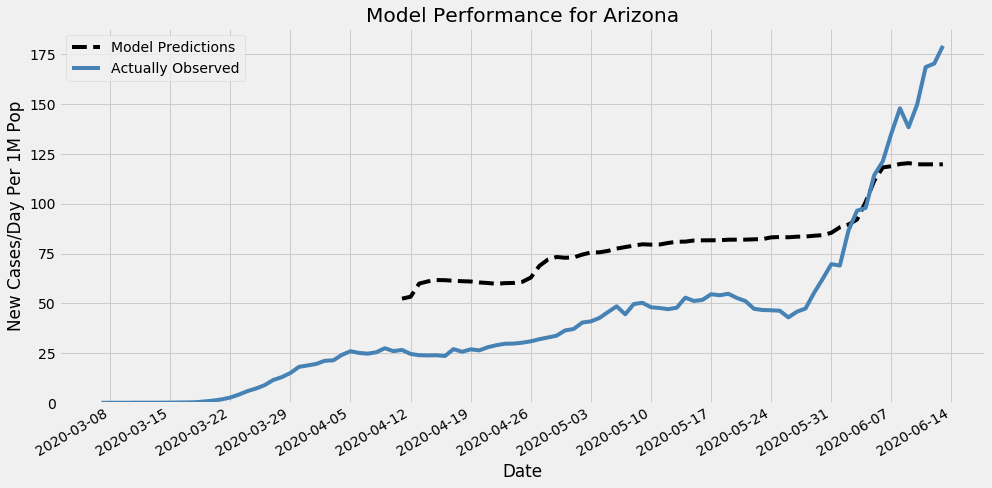

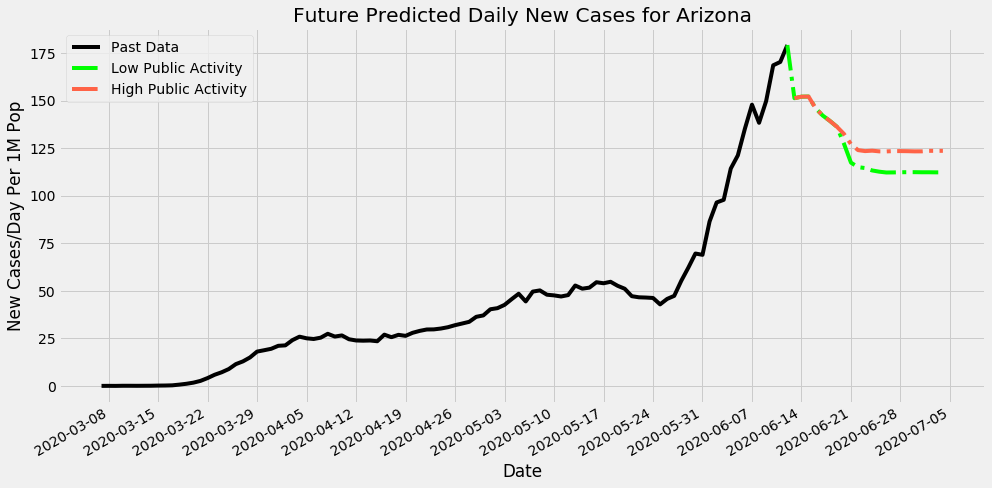

In [331]:
# run_model(state = 'Arizona', min_recovery_factor = 1.2, pop_density_tolerance = 20, SD_delay = 7, train_test_split =0.25, percent_max_cases = 0.45)
run_model(state = 'Arizona', min_recovery_factor = 1, pop_density_tolerance = 9, SD_delay = 7, train_test_split = 0.25, percent_max_cases = 0.65)

The Most similar states to Oklahoma that meet the comparable parameters are: ['Maine' 'Colorado' 'Iowa' 'Vermont' 'Minnesota' 'West Virginia']. These will be used to predict for Oklahoma.
Train/Test Split on day 17 after state reached 50.0 % of maximum daily new cases.
rmse: 36.75227879073137
                                 0
residential(t)            0.023219
parks(t)                  0.016088
transit_stations(t)       0.011794
driving(t)                0.006894
workplaces(t)             0.000815
retail_and_recreation(t)  0.000562
days_elapsed(t)           0.000550
pop_density(t)            0.000363
grocery_and_pharmacy(t)   0.000299


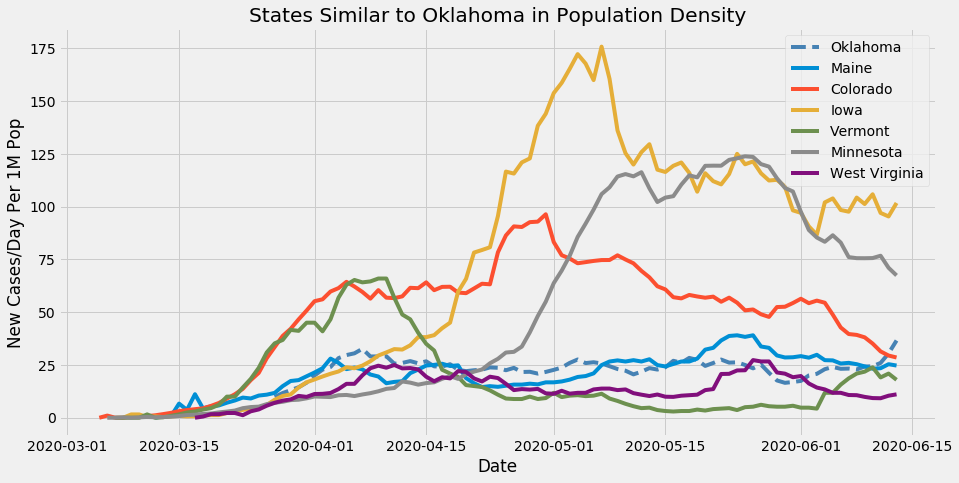

/Users/jbud/Desktop/Galvanize/repos/Covid-19-Forecasting/src/Misc_functions.py:236: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


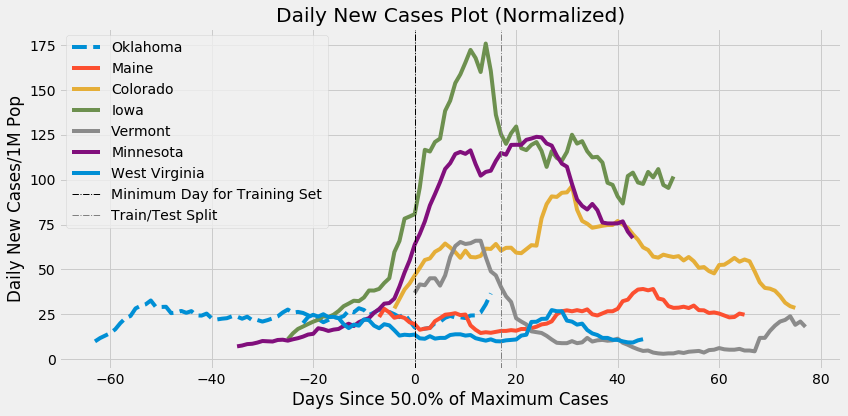

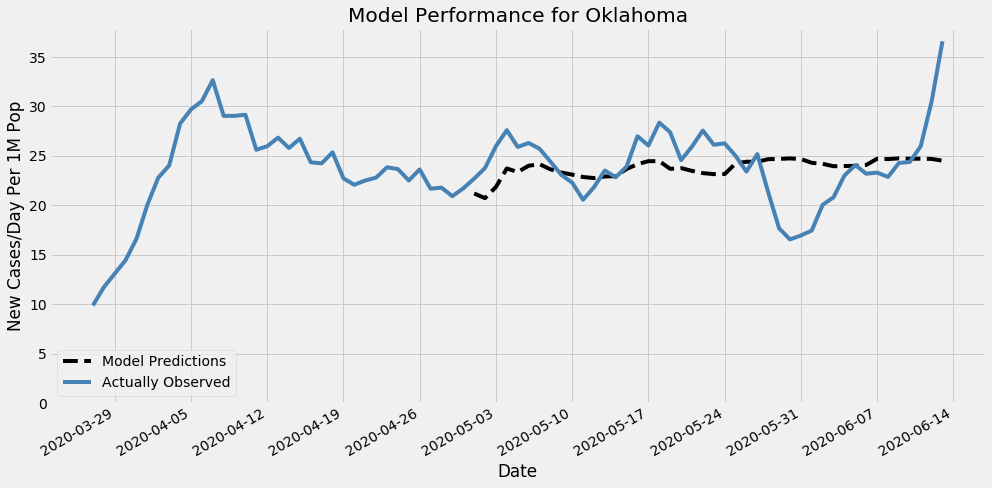

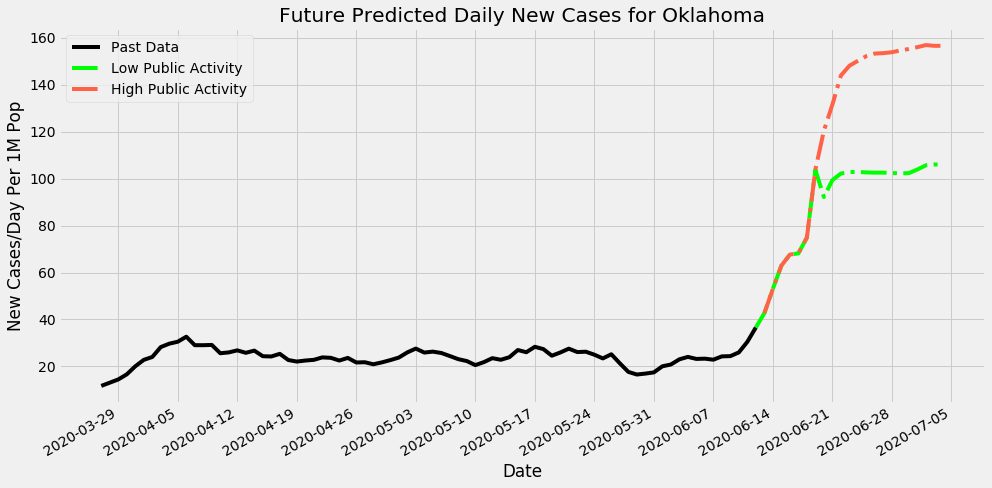

In [286]:
# run_model(state = 'Oklahoma', min_recovery_factor = 1.2, pop_density_tolerance = 20, SD_delay = 7, train_test_split =0.2, percent_max_cases = 0.5)
run_model(state = 'Oklahoma', min_recovery_factor = 1.2, pop_density_tolerance = 20, SD_delay = 7, train_test_split =0.23, percent_max_cases = 0.5)

The Most similar states to Nevada that meet the comparable parameters are: ['North Dakota' 'South Dakota' 'Idaho' 'Nebraska' 'Kansas']. These will be used to predict for Nevada.
Train/Test Split on day 17 after state reached 50.0 % of maximum daily new cases.
rmse: 38.91980719548558
                                 0
workplaces(t)             0.007828
parks(t)                  0.003034
residential(t)            0.001842
days_elapsed(t)           0.001265
retail_and_recreation(t)  0.000923
driving(t)                0.000589
grocery_and_pharmacy(t)   0.000507
transit_stations(t)       0.000423
pop_density(t)            0.000282


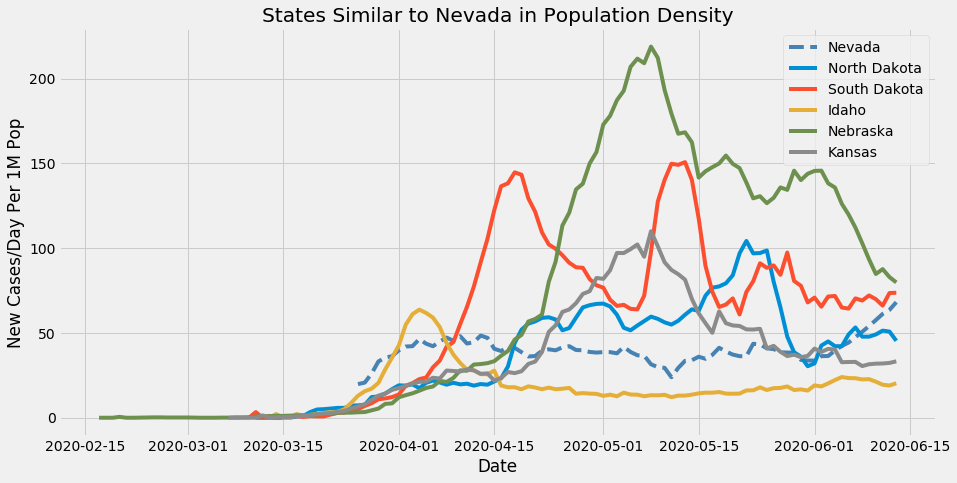

/Users/jbud/Desktop/Galvanize/repos/Covid-19-Forecasting/src/Misc_functions.py:236: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


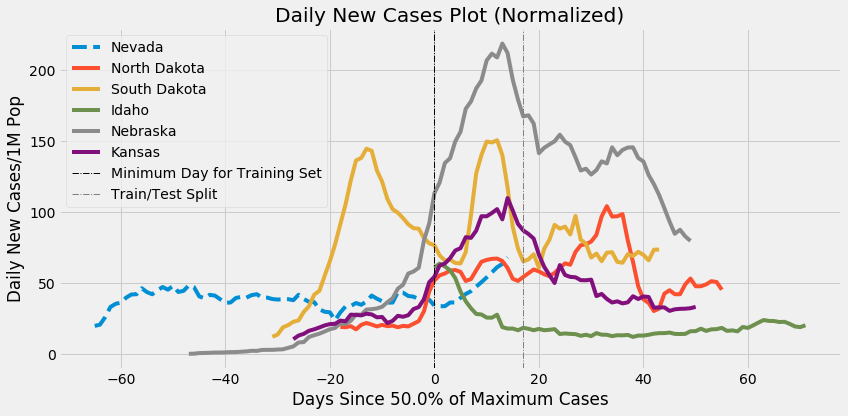

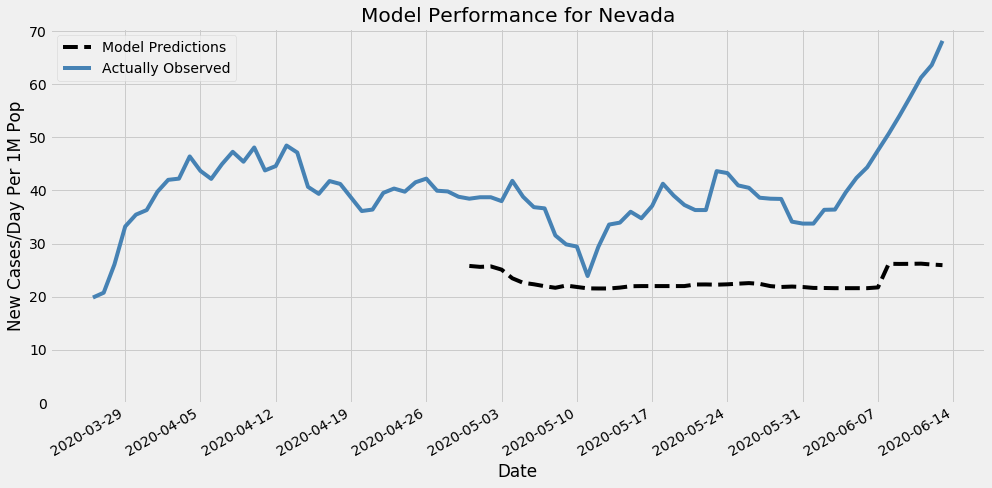

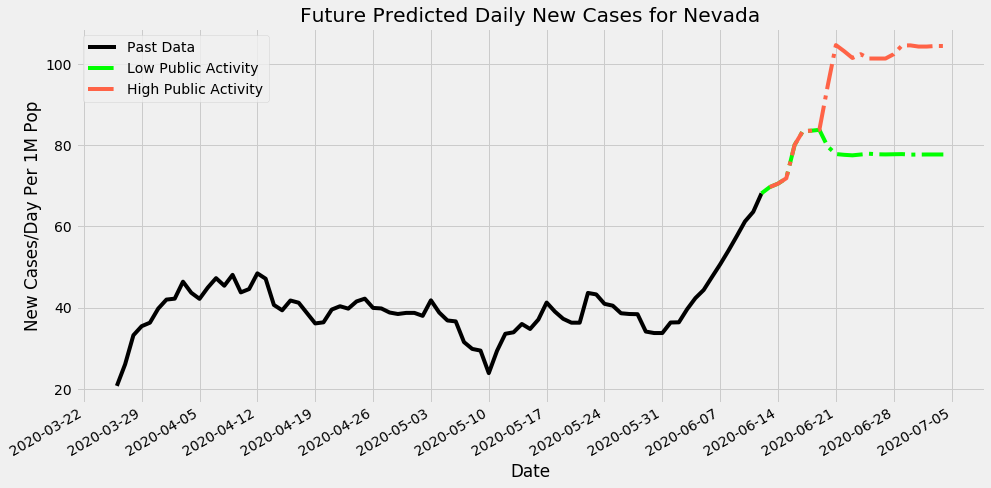

In [279]:
run_model(state = 'Nevada', min_recovery_factor = 2, pop_density_tolerance = 20, SD_delay = 7, train_test_split =0.25, percent_max_cases = 0.5)

The Most similar states to Mississippi that meet the comparable parameters are: ['Colorado' 'Iowa' 'Vermont' 'Minnesota' 'West Virginia']. These will be used to predict for Mississippi.
Train/Test Split on day 19 after state reached 65.0 % of maximum daily new cases.
rmse: 52.83821720303423
                                 0
parks(t)                  0.103826
grocery_and_pharmacy(t)   0.038797
pop_density(t)            0.009924
transit_stations(t)       0.007097
workplaces(t)             0.002915
driving(t)                0.002369
residential(t)            0.001838
days_elapsed(t)           0.000905
retail_and_recreation(t)  0.000690


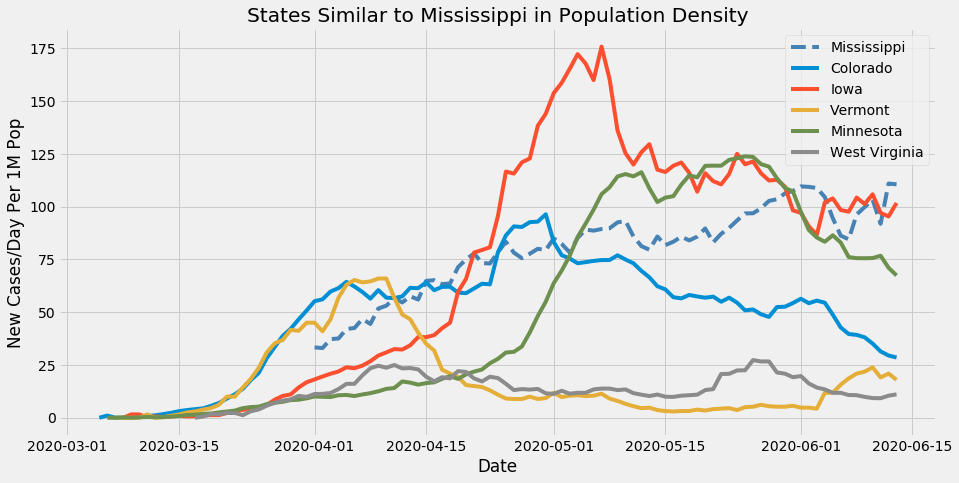

/Users/jbud/Desktop/Galvanize/repos/Covid-19-Forecasting/src/Misc_functions.py:236: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


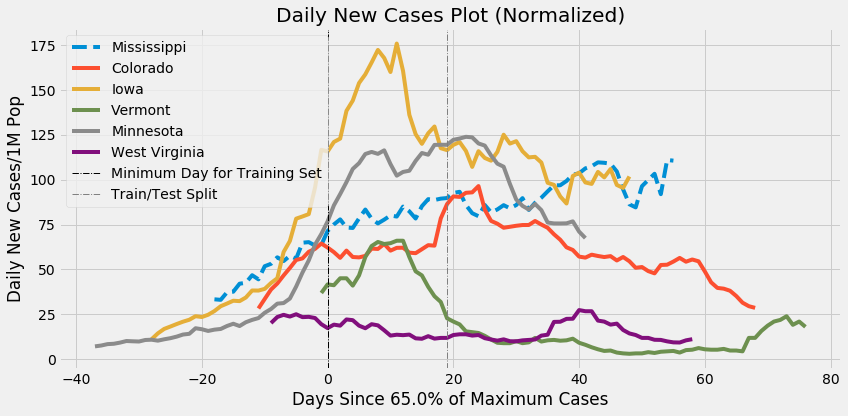

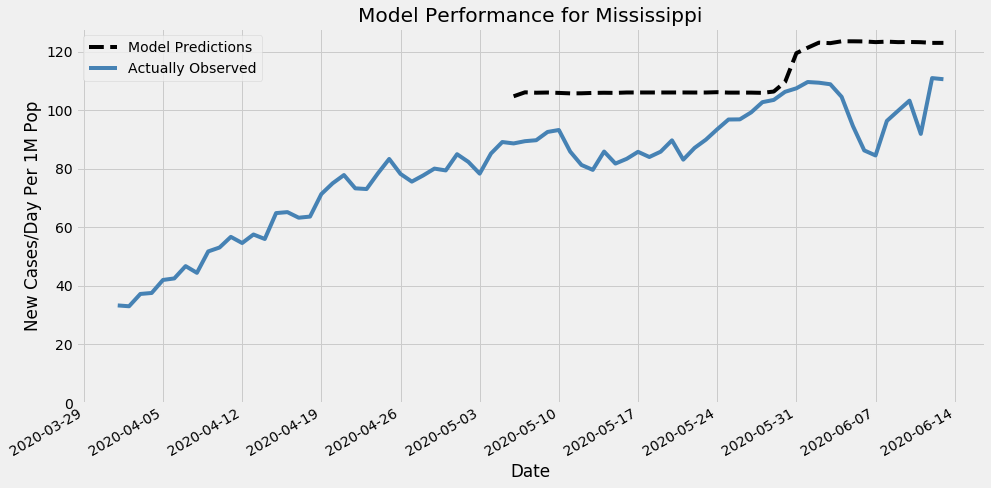

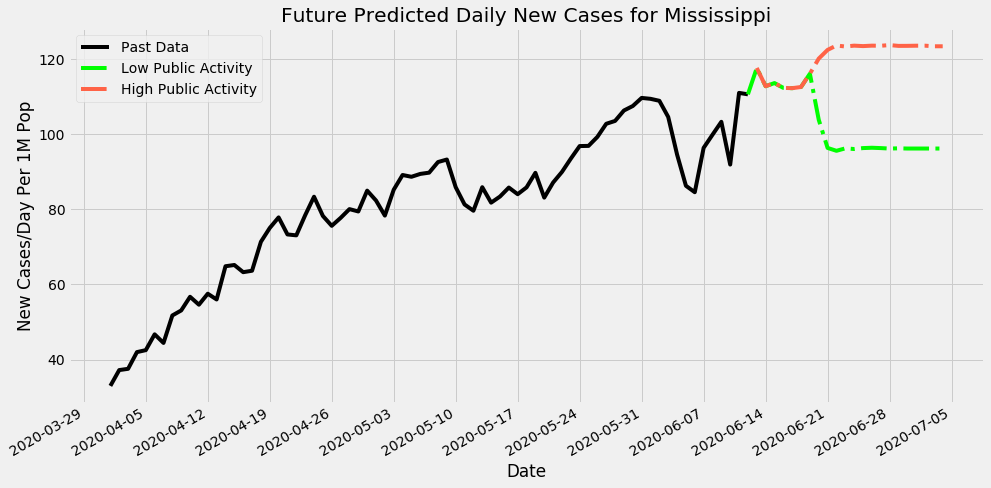

In [306]:
run_model(state = 'Mississippi', min_recovery_factor = 1.5, pop_density_tolerance = 20, SD_delay = 7, train_test_split =0.25, percent_max_cases = 0.65)

The Most similar states to Texas that meet the comparable parameters are: ['Montana' 'North Dakota' 'South Dakota' 'Idaho' 'Nebraska' 'Kansas'
 'Colorado' 'Vermont' 'West Virginia' 'Louisiana' 'New Hampshire'
 'Michigan' 'Hawaii' 'Illinois' 'Pennsylvania' 'Ohio']. These will be used to predict for Texas.
Train/Test Split on day 17 after state reached 45.0 % of maximum daily new cases.
rmse: 36.31198592844298
                                 0
grocery_and_pharmacy(t)   0.013236
days_elapsed(t)           0.002178
driving(t)                0.001453
retail_and_recreation(t)  0.001350
workplaces(t)             0.000912
transit_stations(t)       0.000852
parks(t)                  0.000766
residential(t)            0.000559
pop_density(t)            0.000361


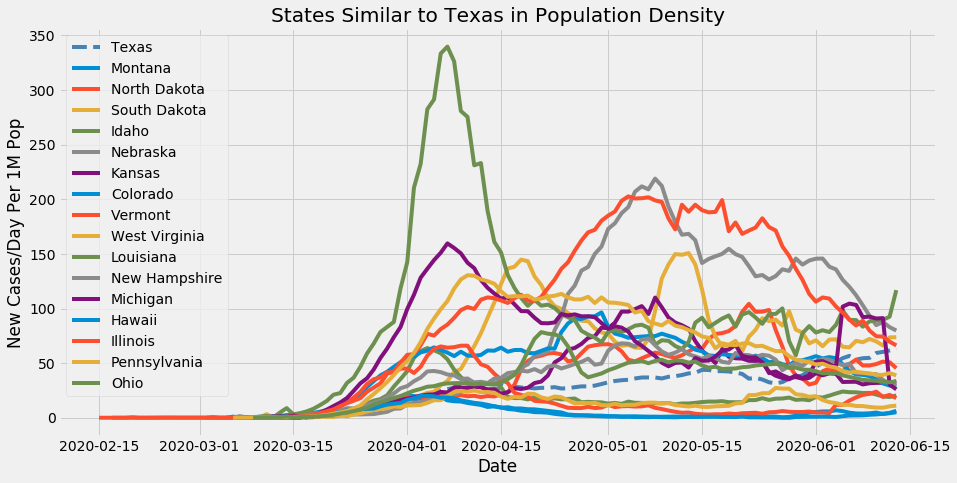

/Users/jbud/Desktop/Galvanize/repos/Covid-19-Forecasting/src/Misc_functions.py:236: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


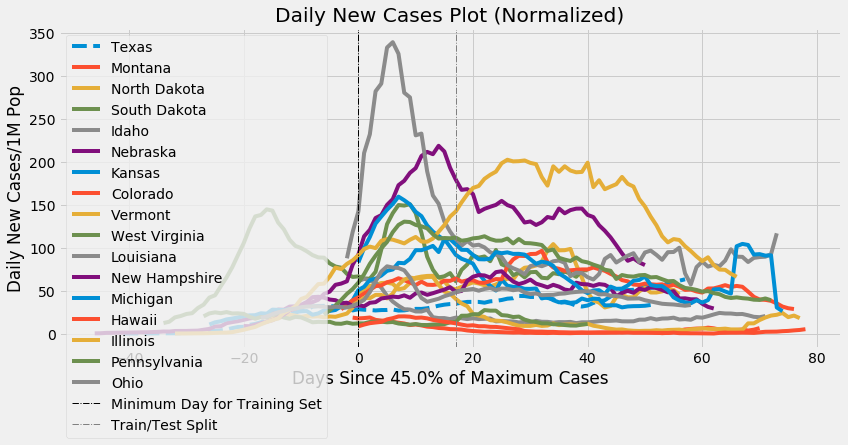

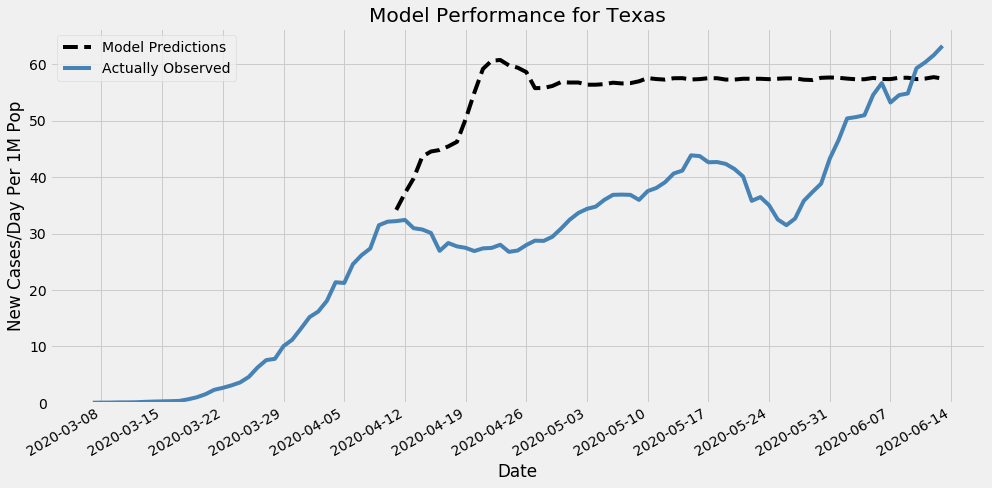

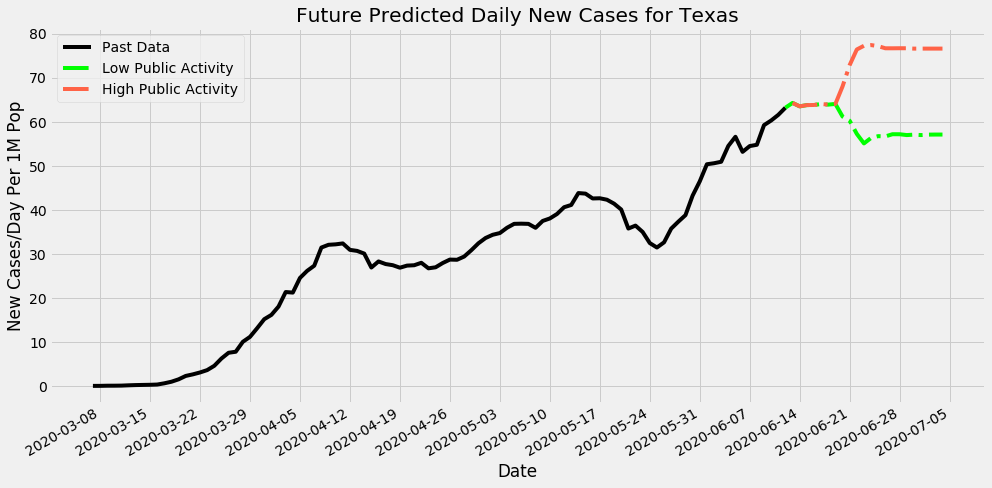

In [297]:
run_model(state = 'Texas', min_recovery_factor = 2, pop_density_tolerance = 250, SD_delay = 7, train_test_split =0.22, percent_max_cases = 0.45)

The Most similar states to North Carolina that meet the comparable parameters are: ['Virginia' 'Hawaii' 'Illinois']. These will be used to predict for North Carolina.
Train/Test Split on day 22 after state reached 60.0 % of maximum daily new cases.
rmse: 48.03632736858301
                                 0
pop_density(t)            0.067713
parks(t)                  0.062343
residential(t)            0.003154
retail_and_recreation(t)  0.002950
transit_stations(t)       0.001449
days_elapsed(t)           0.001069
workplaces(t)             0.001062
driving(t)                0.000824
grocery_and_pharmacy(t)   0.000346


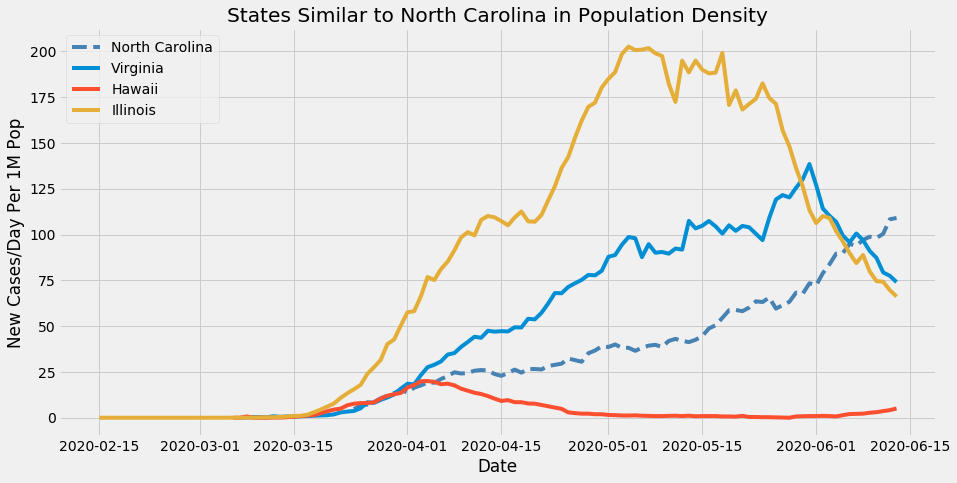

/Users/jbud/Desktop/Galvanize/repos/Covid-19-Forecasting/src/Misc_functions.py:236: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


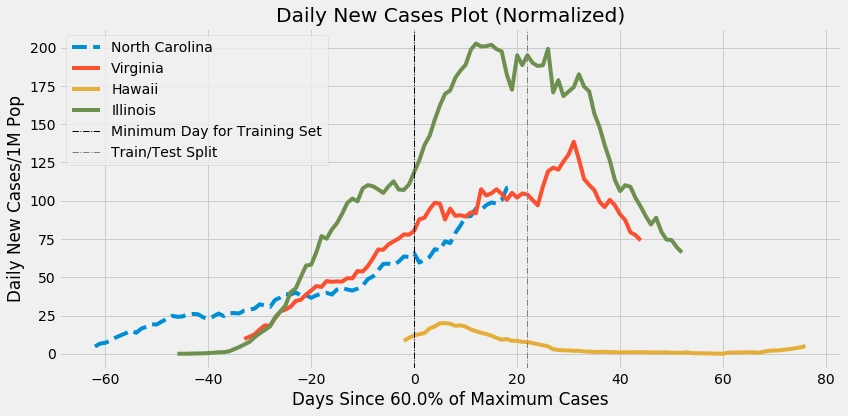

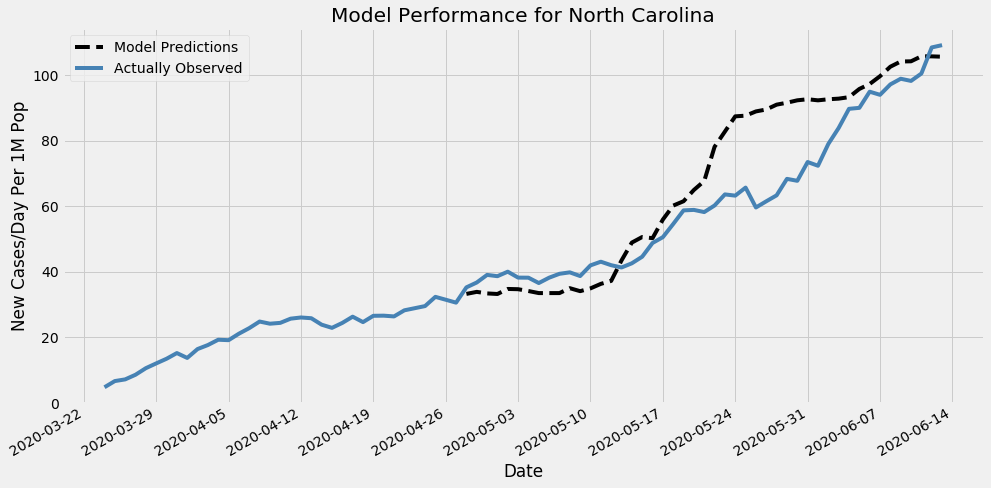

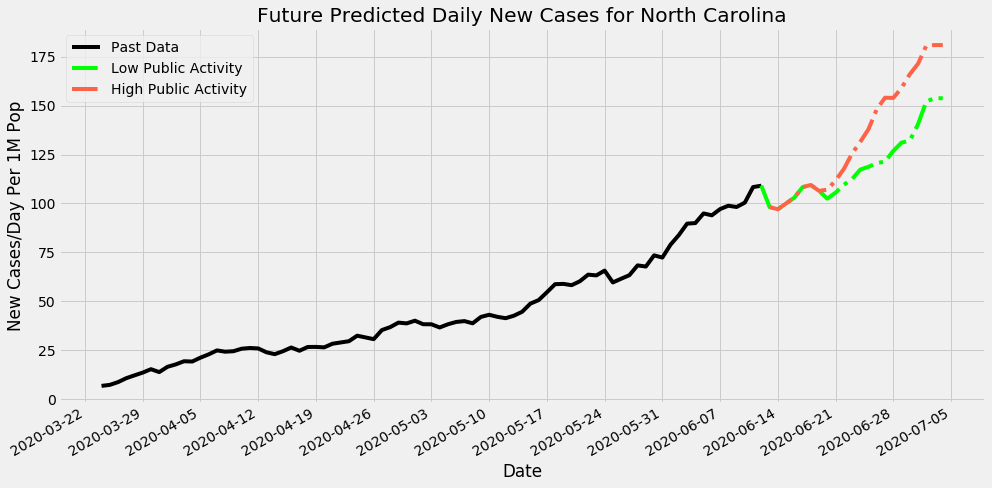

In [19]:
run_model(state = 'North Carolina', min_recovery_factor = 1.2, pop_density_tolerance = 20, SD_delay = 7, train_test_split =0.3, percent_max_cases = 0.6)

The Most similar states to South Carolina that meet the comparable parameters are: ['West Virginia' 'Louisiana' 'New Hampshire' 'Michigan' 'Hawaii'
 'Illinois']. These will be used to predict for South Carolina.
Train/Test Split on day 21 after state reached 35.0 % of maximum daily new cases.
rmse: 64.20818017596798
                                 0
grocery_and_pharmacy(t)   0.015067
retail_and_recreation(t)  0.012128
workplaces(t)             0.007867
transit_stations(t)       0.006205
residential(t)            0.003601
driving(t)                0.001596
pop_density(t)            0.001434
parks(t)                  0.001265
days_elapsed(t)           0.000313


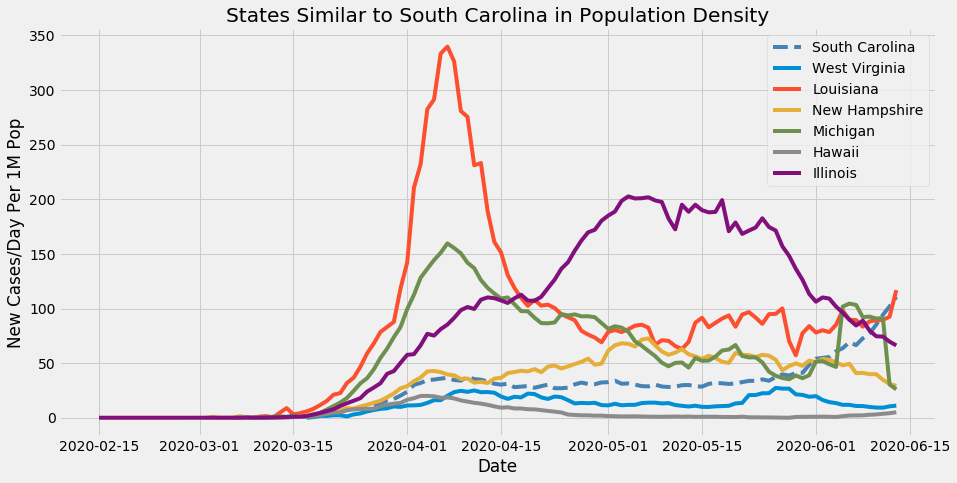

/Users/jbud/Desktop/Galvanize/repos/Covid-19-Forecasting/src/Misc_functions.py:236: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


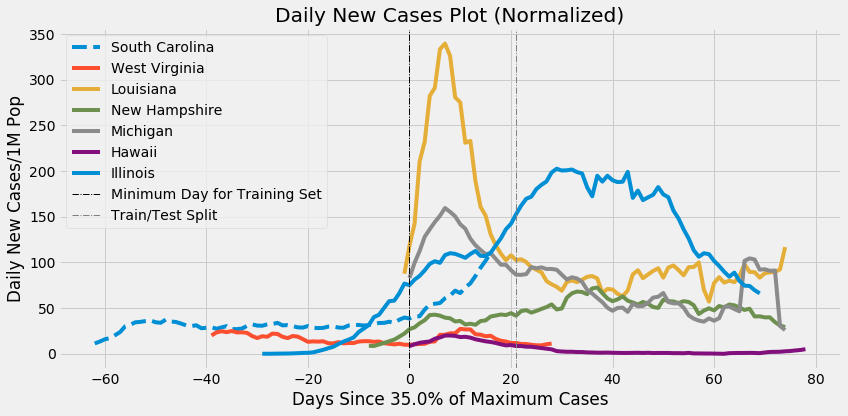

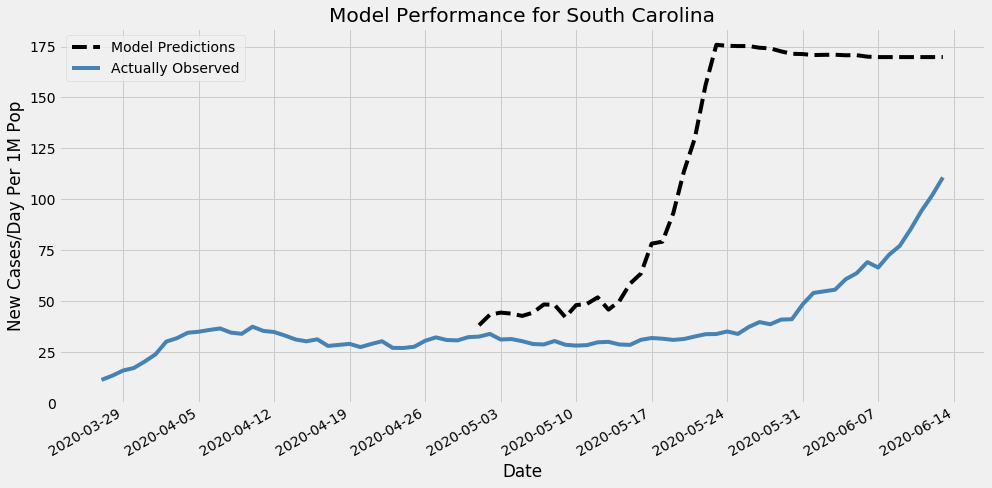

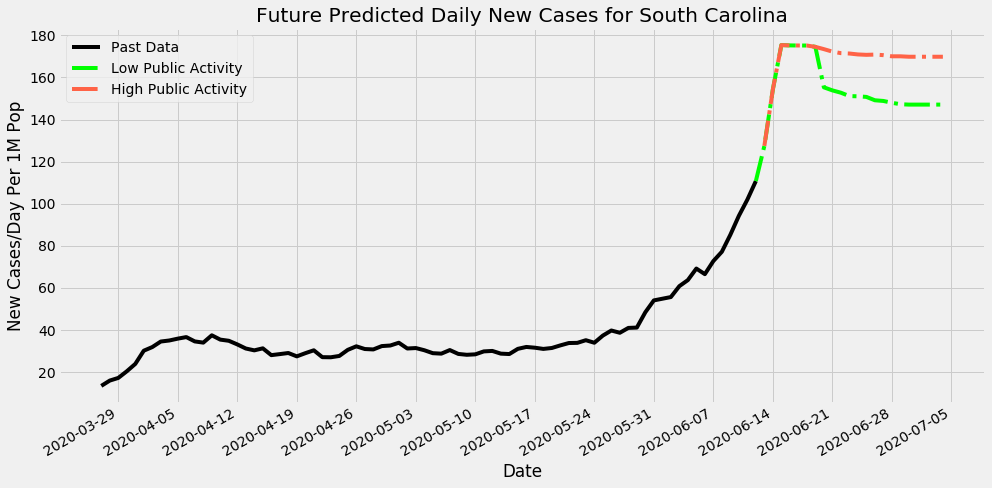

In [196]:
run_model(state = 'South Carolina', min_recovery_factor = 2, pop_density_tolerance = 100, SD_delay = 7, train_test_split = 21, percent_max_cases = .35)

The Most similar states to Michigan that meet the comparable parameters are: ['New Hampshire' 'Tennessee' 'Michigan' 'Indiana']. These will be used to predict for Michigan.
Train/Test Split on day 18 after state reached 75.0 % of maximum daily new cases.
rmse: 35.27608082843603
                                 0
driving(t)                0.077685
pop_density(t)            0.050234
parks(t)                  0.009688
retail_and_recreation(t)  0.006417
grocery_and_pharmacy(t)   0.002672
days_elapsed(t)           0.001971
transit_stations(t)       0.001685
workplaces(t)             0.001397
residential(t)            0.001309


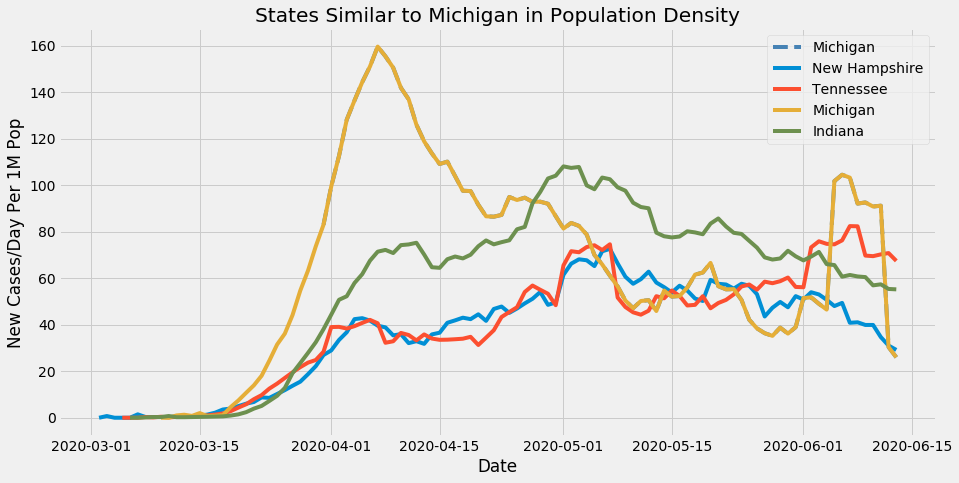

/Users/jbud/Desktop/Galvanize/repos/Covid-19-Forecasting/src/Misc_functions.py:236: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


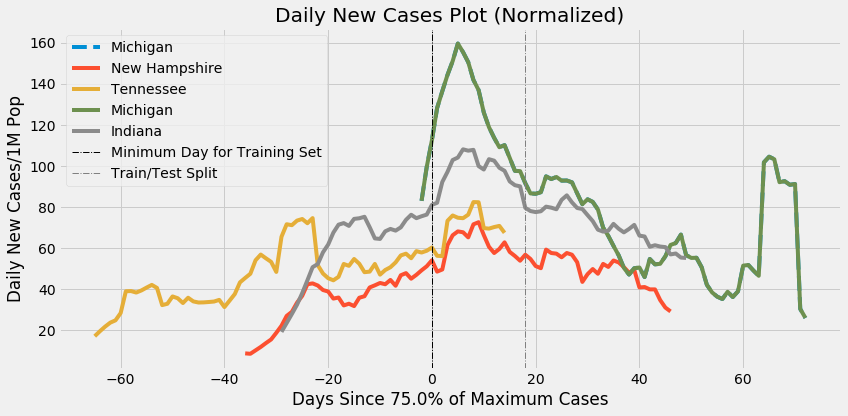

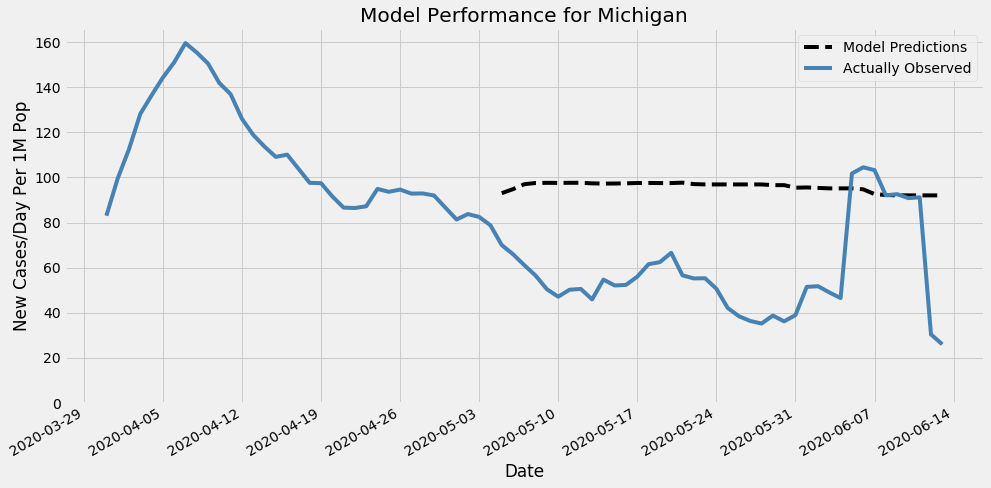

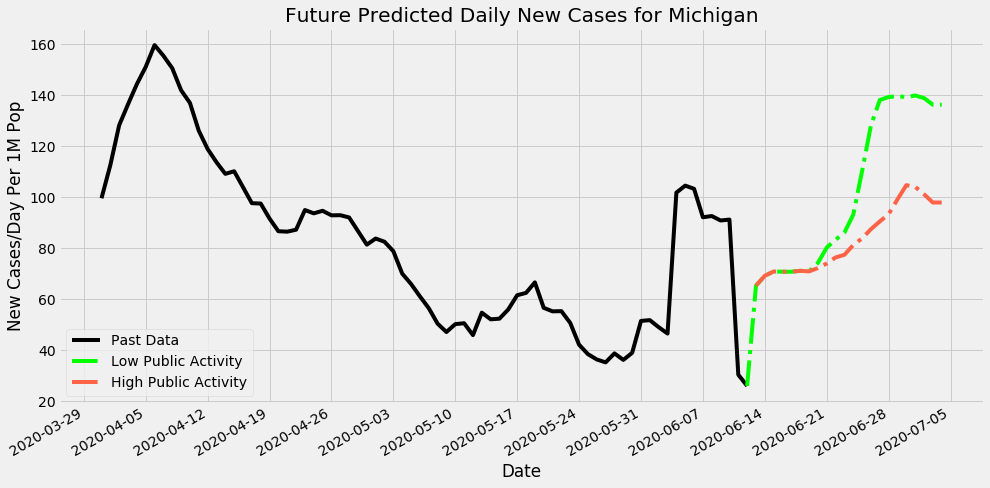

In [67]:
run_model(state = 'Michigan', min_recovery_factor = 1.2, pop_density_tolerance = 35, SD_delay = 7, train_test_split =0.25, percent_max_cases = 0.75)

The Most similar states to California that meet the comparable parameters are: ['Virginia' 'Hawaii' 'Illinois' 'Pennsylvania' 'Ohio']. These will be used to predict for California.
Train/Test Split on day 45 after state reached 37.0 % of maximum daily new cases.
rmse: 43.69548485314088
                                 0
parks(t)                  0.006622
days_elapsed(t)           0.001020
residential(t)            0.001006
retail_and_recreation(t)  0.000933
workplaces(t)             0.000850
driving(t)                0.000612
pop_density(t)            0.000587
transit_stations(t)       0.000539
grocery_and_pharmacy(t)   0.000365


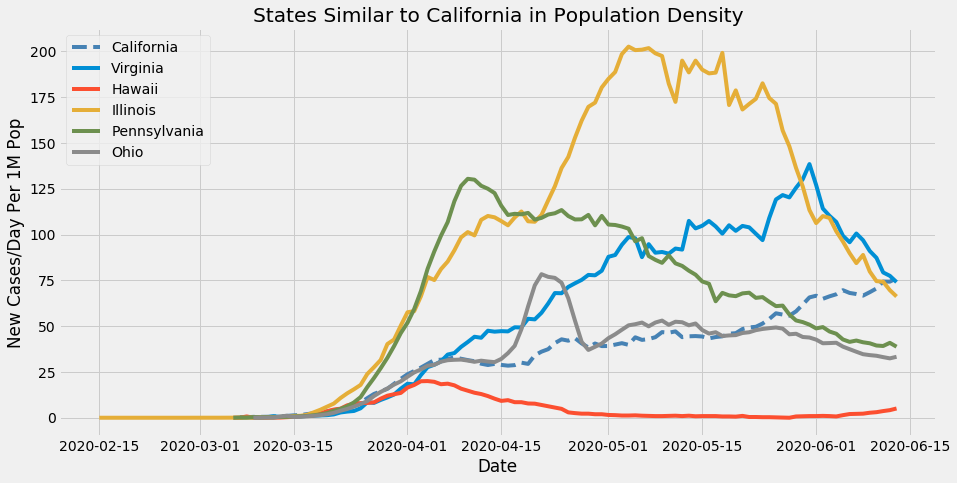

/Users/jbud/Desktop/Galvanize/repos/Covid-19-Forecasting/src/Misc_functions.py:236: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


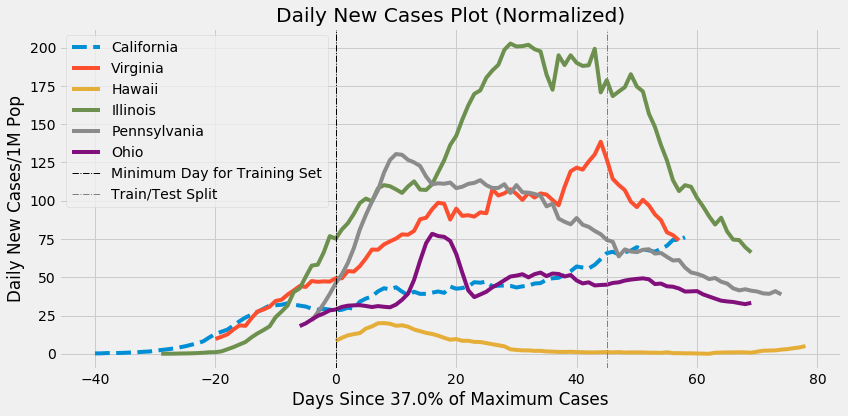

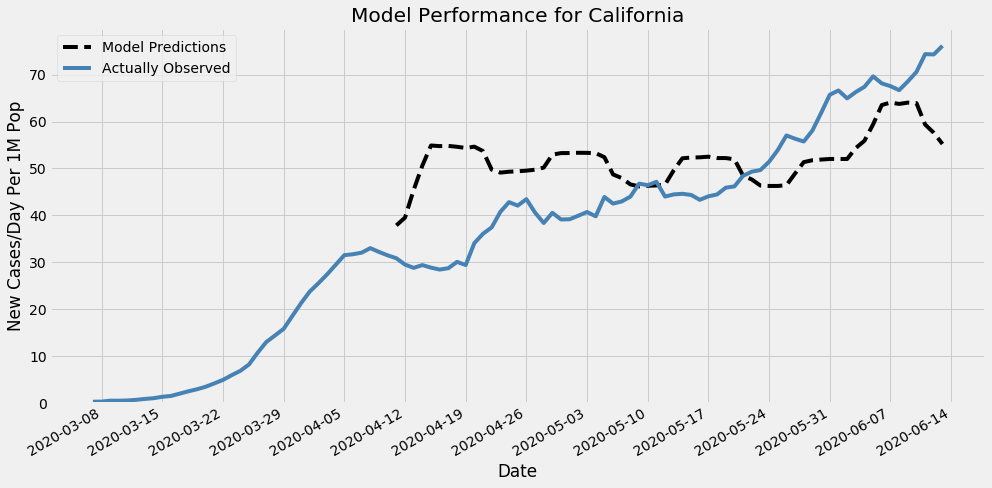

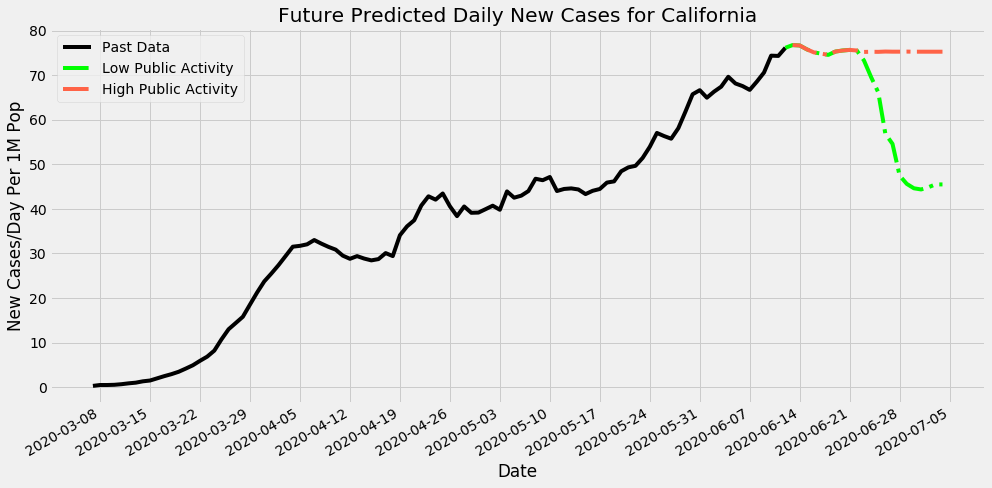

In [147]:
# for each in range(7, 13, 1):
run_model(state = 'California', min_recovery_factor = 1.3, pop_density_tolerance = 40, SD_delay = 10, train_test_split = 45, percent_max_cases = 0.37, test_row_start = 15)

The Most similar states to Arkansas that meet the comparable parameters are: ['Kansas' 'Colorado' 'Vermont' 'Minnesota' 'West Virginia']. These will be used to predict for Arkansas.
Train/Test Split on day 19 after state reached 25.0 % of maximum daily new cases.
rmse: 42.11389639843232
                                 0
parks(t)                  0.084271
grocery_and_pharmacy(t)   0.009663
transit_stations(t)       0.006917
retail_and_recreation(t)  0.005974
driving(t)                0.004266
pop_density(t)            0.003482
residential(t)            0.001896
workplaces(t)             0.001182
days_elapsed(t)           0.000657


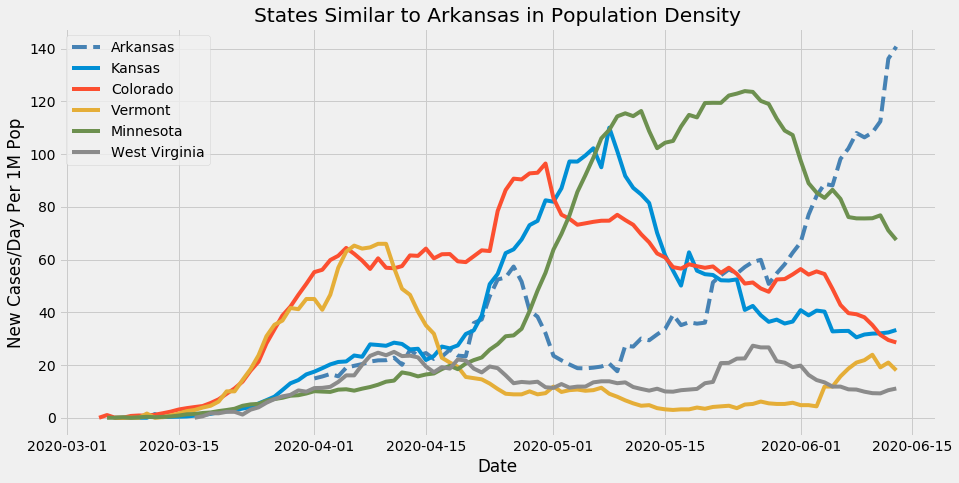

/Users/jbud/Desktop/Galvanize/repos/Covid-19-Forecasting/src/Misc_functions.py:236: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


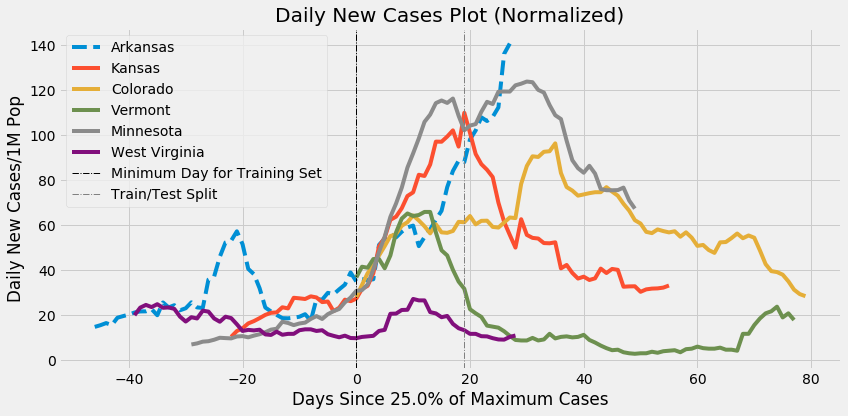

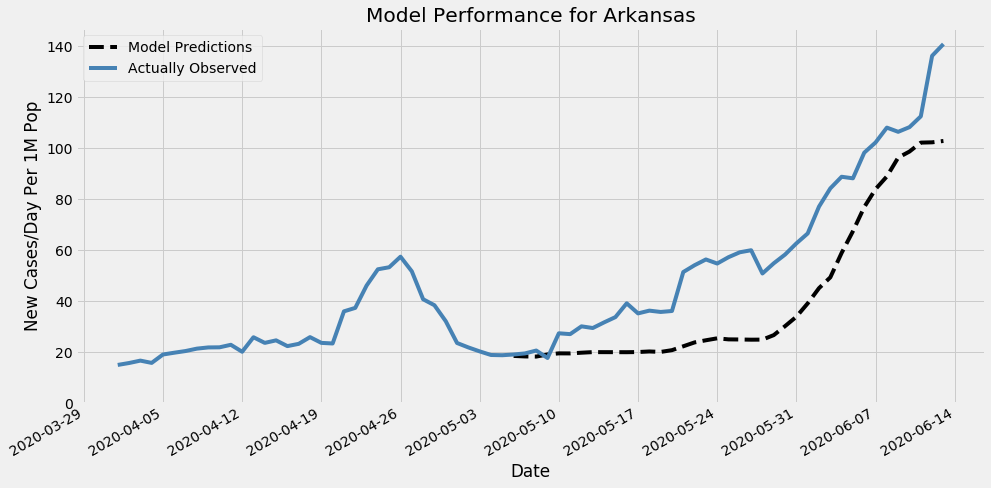

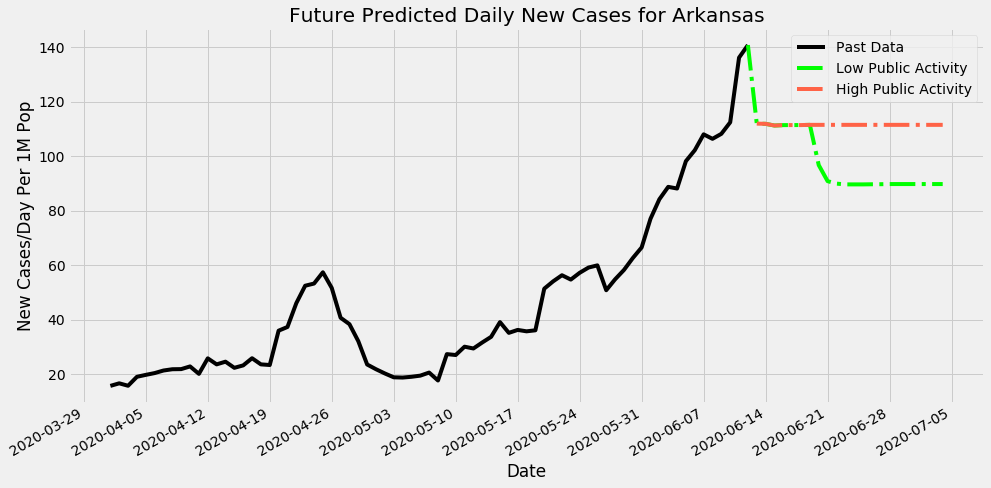

In [218]:
# run_model(state = 'Arkansas', min_recovery_factor = 1.8, pop_density_tolerance = 30, SD_delay = 7, train_test_split =0.22, percent_max_cases = 0.4, test_row_start = 15)
# run_model(state = 'Arkansas', min_recovery_factor = 1.8, pop_density_tolerance = 30, SD_delay = 7, train_test_split =0.22, percent_max_cases = 0.3, test_row_start = 15)
run_model(state = 'Arkansas', min_recovery_factor = 1.8, pop_density_tolerance = 30, SD_delay = 7, train_test_split =0.25, percent_max_cases = 0.25, test_row_start = 15)

The Most similar states to Florida that meet the comparable parameters are: ['Hawaii' 'Illinois' 'Pennsylvania' 'New York' 'Delaware']. These will be used to predict for Florida.
Train/Test Split on day 35 after state reached 50.0 % of maximum daily new cases.
rmse: 134.8194852906764
                                 0
driving(t)                0.007550
pop_density(t)            0.006731
parks(t)                  0.002602
grocery_and_pharmacy(t)   0.000701
workplaces(t)             0.000405
retail_and_recreation(t)  0.000382
days_elapsed(t)           0.000298
transit_stations(t)       0.000280
residential(t)            0.000172


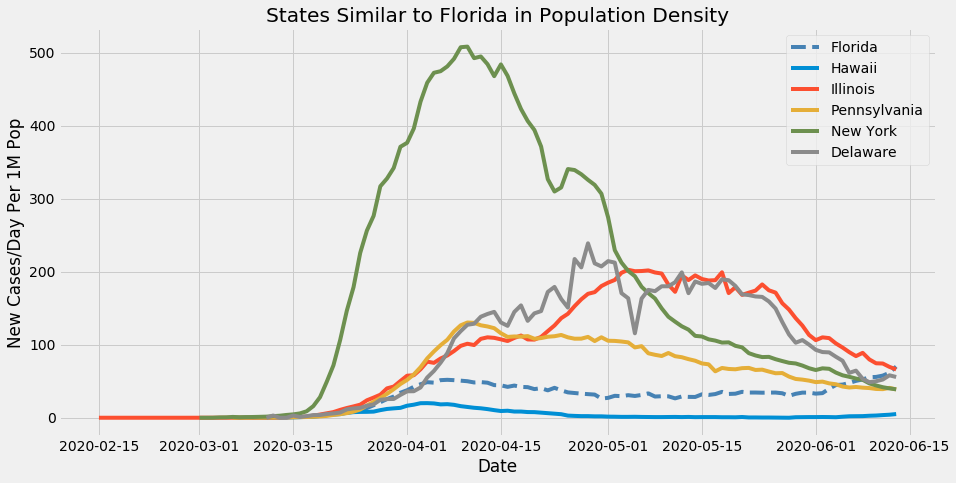

/Users/jbud/Desktop/Galvanize/repos/Covid-19-Forecasting/src/Misc_functions.py:236: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


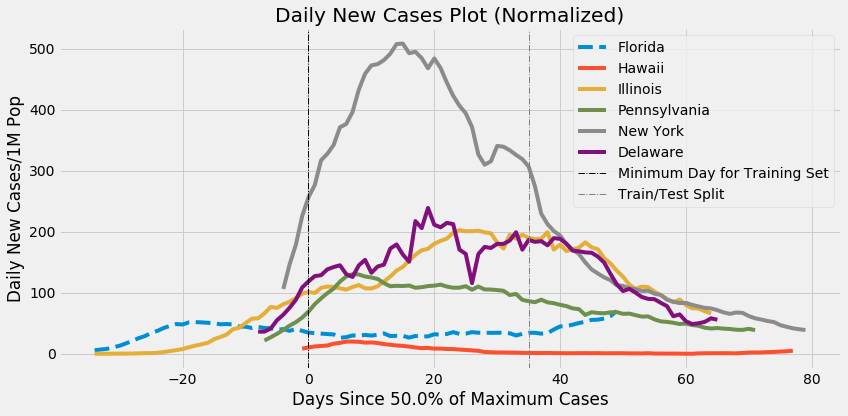

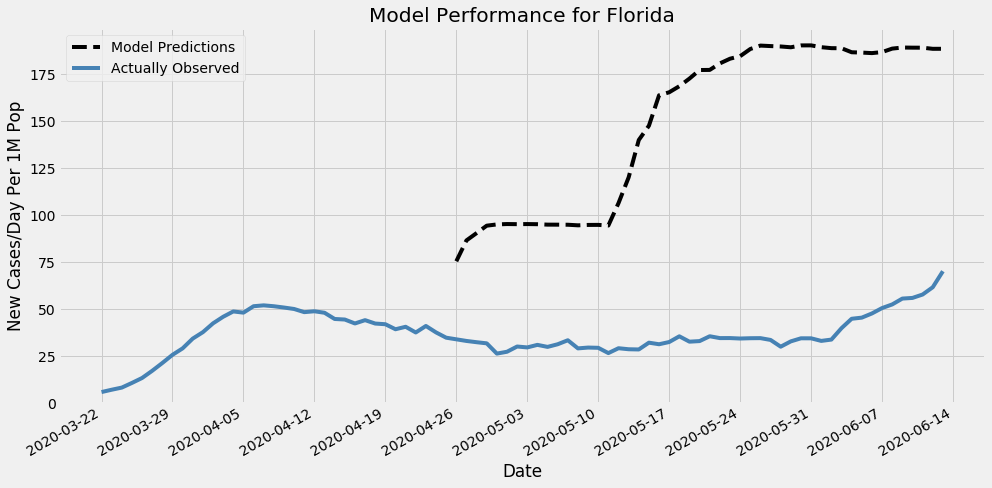

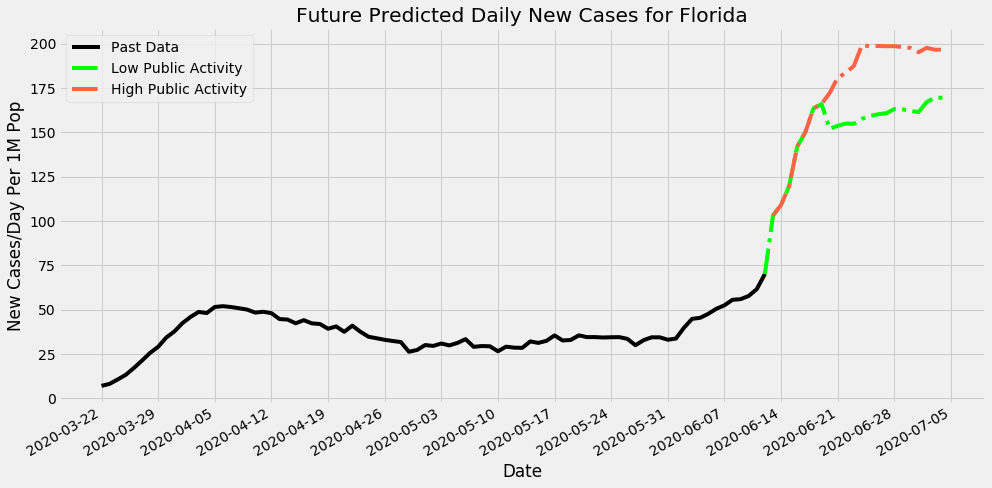

In [250]:
run_model(state = 'Florida', min_recovery_factor = 2.5, pop_density_tolerance = 200, SD_delay = 7, train_test_split =0.45, percent_max_cases = 0.5, test_row_start = 15)

The Most similar states to Alabama that meet the comparable parameters are: ['Vermont' 'Minnesota' 'West Virginia' 'Louisiana' 'Wisconsin']. These will be used to predict for Alabama.
Train/Test Split on day 26 after state reached 65.0 % of maximum daily new cases.
rmse: 15.281524928045927
                                 0
grocery_and_pharmacy(t)   0.031088
transit_stations(t)       0.005538
workplaces(t)             0.001555
retail_and_recreation(t)  0.001270
parks(t)                  0.001211
residential(t)            0.000835
days_elapsed(t)           0.000662
driving(t)                0.000427
pop_density(t)            0.000029


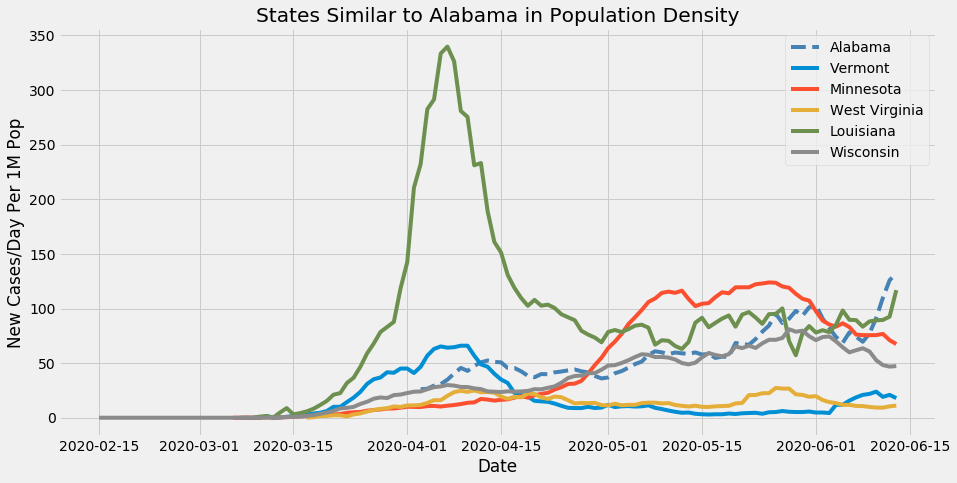

/Users/jbud/Desktop/Galvanize/repos/Covid-19-Forecasting/src/Misc_functions.py:236: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


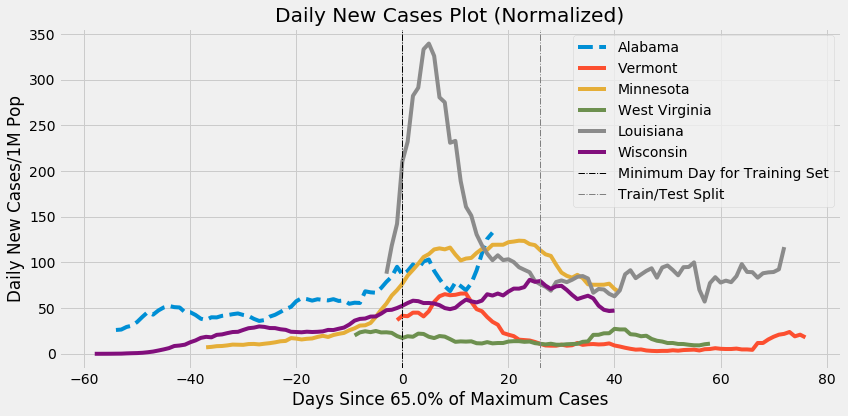

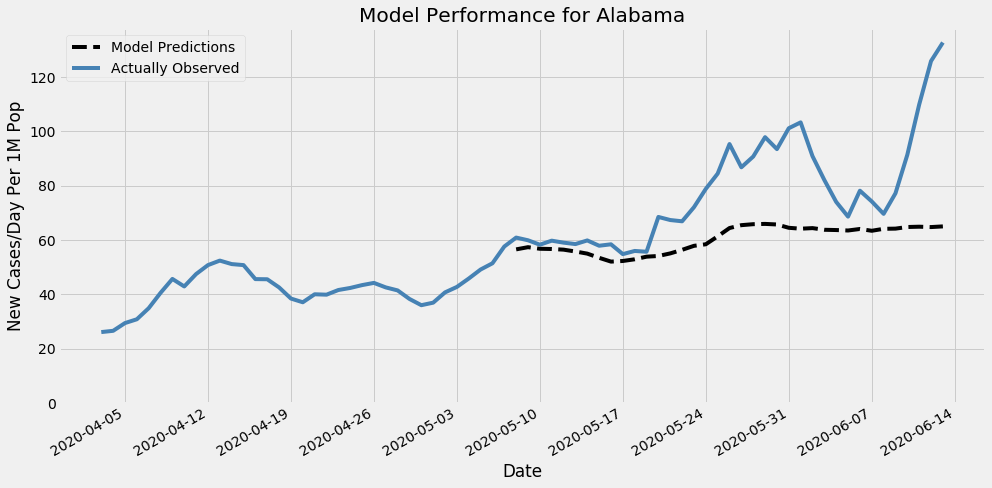

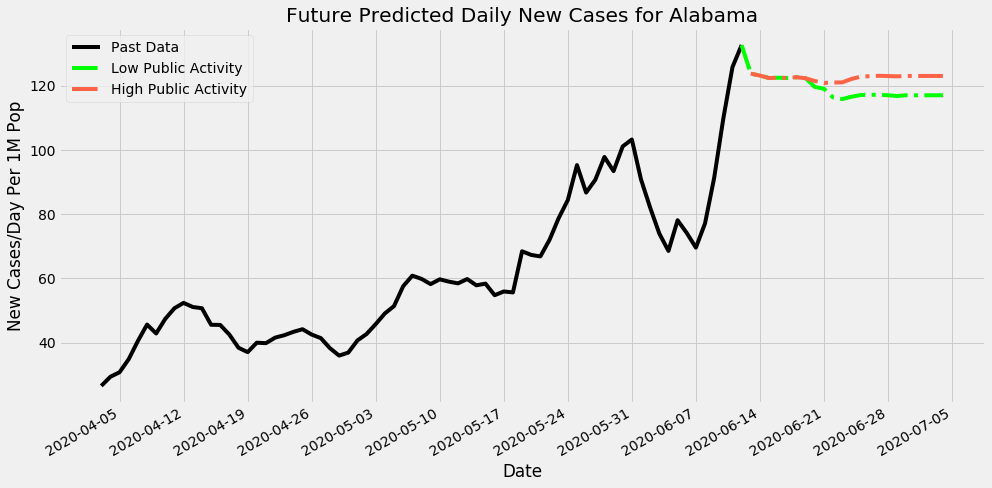

In [352]:
run_model(state = 'Alabama', min_recovery_factor = 1.7, pop_density_tolerance = 30, SD_delay = 7, train_test_split =0.35, percent_max_cases = 0.65, test_row_start = 15)

In [ ]:
grocery_and_pharmacy(t)   0.031088
transit_stations(t)       0.005538
workplaces(t)             0.001555
retail_and_recreation(t)  0.001270
parks(t)                  0.001211
residential(t)            0.000835
days_elapsed(t)           0.000662
driving(t)                0.000427
pop_density(t)            0.000029

In [8]:
MN_df = covid_df[covid_df['state'] == 'Minnesota']
IA_df = covid_df[covid_df['state'] == 'Iowa']
MN_df = replace_with_moving_averages(MN_df, ['New_Cases_per_pop'], 0)
IA_df = replace_with_moving_averages(IA_df, ['New_Cases_per_pop'], 0)

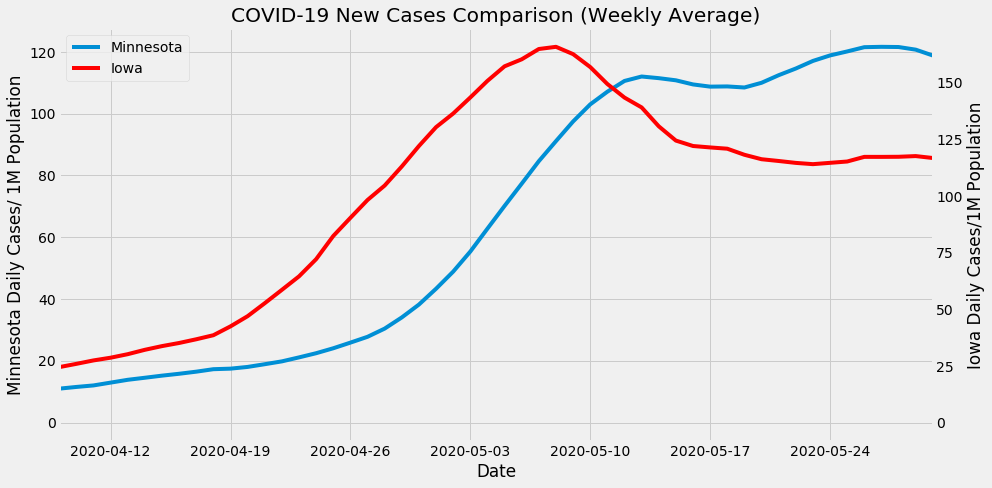

In [9]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize = (14, 7))
x = MN_df['days_elapsed']
y = MN_df['New_Cases_per_pop']
ax.plot(x.apply(convert_to_date), y, label = 'Minnesota')
ax.set_ylabel('{} Daily Cases/ 1M Population'.format('Minnesota'))
ax.set_xlim(convert_to_date(54), convert_to_date(105))
ax.set_xlabel('Date')
ax.set_title('COVID-19 New Cases Comparison (Weekly Average)')
x = IA_df['days_elapsed']
y = IA_df['New_Cases_per_pop']

ax2 = ax.twinx()
ax2.plot(x.apply(convert_to_date), y, label = 'Iowa', c = 'red')
ax2.set_ylabel('{} Daily Cases/1M Population'.format('Iowa'))
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1 + h2, l1 + l2, loc = 2)
ax2.grid(None)
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
fig.tight_layout()
fig.savefig('images/MN_IA', dpi = 300)


In [13]:
states = ['Vermont']
x_starts, VT_df = normalize_days(states, covid_df, percent_max = 0.25, plot = False, save_x_starts = True)
VT = VT_df[0]
VT['days_since_start'] += 30
# plt.plot(VT_df['days_since_start'].values, VT_df['New_Cases_per_pop'].values)

Text(0, 0.5, 'Daily New Cases per 1M Pop')

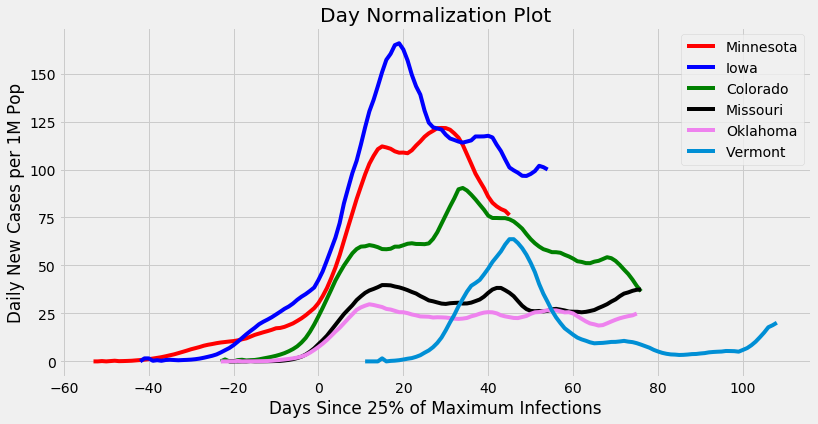

In [14]:
import numpy as np

states = ['Minnesota', 'Iowa', 'Colorado', 'Missouri', 'Oklahoma']

x_starts, df = normalize_days(states, covid_df, percent_max = 0.25, plot = True, save_x_starts = True)
plt.plot(VT['days_since_start'].values, VT['New_Cases_per_pop'].values, label = 'Vermont')
plt.legend()
plt.xlabel('Days Since 25% of Maximum Infections')
plt.ylabel('Daily New Cases per 1M Pop')

In [15]:
normalized_df = VT.copy()
normalized_df = normalized_df.append(df)

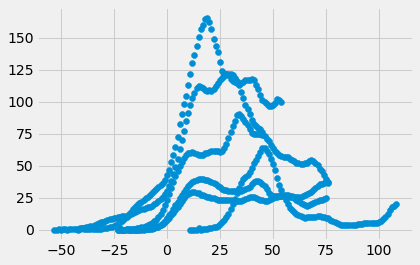

In [16]:
plt.scatter(normalized_df['days_since_start'], normalized_df['New_Cases_per_pop'])

In [17]:
normalized_df.drop('state', axis = 1, inplace = True)

In [18]:
values = normalized_df.values
num_cols = len(normalized_df.columns)
ts_frame_data = series_to_supervised(values, normalized_df.columns, 21, 1)
ts_frame_data = ts_frame_data.iloc[:,
                                    num_cols-1:-num_cols + 1:num_cols].join(ts_frame_data.iloc[:, -num_cols:])
ts_frame_data = ts_frame_data[ts_frame_data['days_since_start(t)'] >= 10]
ts_y = ts_frame_data.pop('New_Cases_per_pop(t)')
ts_x = ts_frame_data

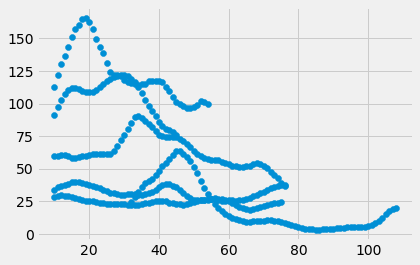

In [19]:
plt.scatter(ts_x['days_since_start(t)'], ts_y)

In [20]:
ts_x.rename(columns = {'days_since_start(t)' : 'days_elapsed(t)'}, inplace = True)

In [21]:
rf_model = reg_model(ts_x, ts_y)
rf_model.rand_forest(n_trees = 100)
rf_model.evaluate_model(print_err_metric = True)

rmse: 6.6572628901141675


6.6572628901141675

In [22]:
# MN_df = normalized_df[normalized_df['state'] == 'Minnesota']
# normalized_df = normalized_df[normalized_df['state'] != 'Minnesota']

In [22]:
min_vals = normalized_df.min().iloc[2:9]
max_vals = normalized_df.max().iloc[2:9]
max_SD = list(min_vals[:5])
max_SD.extend([max_vals[5], min_vals[6]])
min_SD = list(max_vals[:5])
min_SD.extend([min_vals[5], max_vals[6]])

In [23]:
MN_df
values = MN_df.values
num_cols = len(MN_df.columns)
ts_frame_data = series_to_supervised(values, MN_df.columns, 21, 1)
ts_frame_data = ts_frame_data.iloc[:,num_cols-1:-num_cols + 1:num_cols].join(ts_frame_data.iloc[:, -num_cols:])

MN_ts_y = ts_frame_data.pop('New_Cases_per_pop(t)')
MN_ts_x = ts_frame_data
MN_ts_x.rename(columns = {'days_since_start(t)' : 'days_elapsed(t)'}, inplace = True)

In [24]:
high, low = max_SD, min_SD
columns = ['Retail/Recreation %', 'Grocery/Pharmacy %', 'Parks %',
           'Transit Stations %', 'Workplaces %', 'Residential %', 'Driving %']
SD_Table = round(pd.DataFrame(
    [np.array(high), np.array(low)], columns=columns) * 100, 2)
SD_Table[''] = ['High', 'Low']
SD_Table.set_index('', inplace=True)

In [26]:
def denormalize_date(x, x_start, extra = 0):
    return convert_to_date(x + x_start + extra)

In [27]:
MN_ts_x.drop('state(t)', axis = 1, inplace = True)

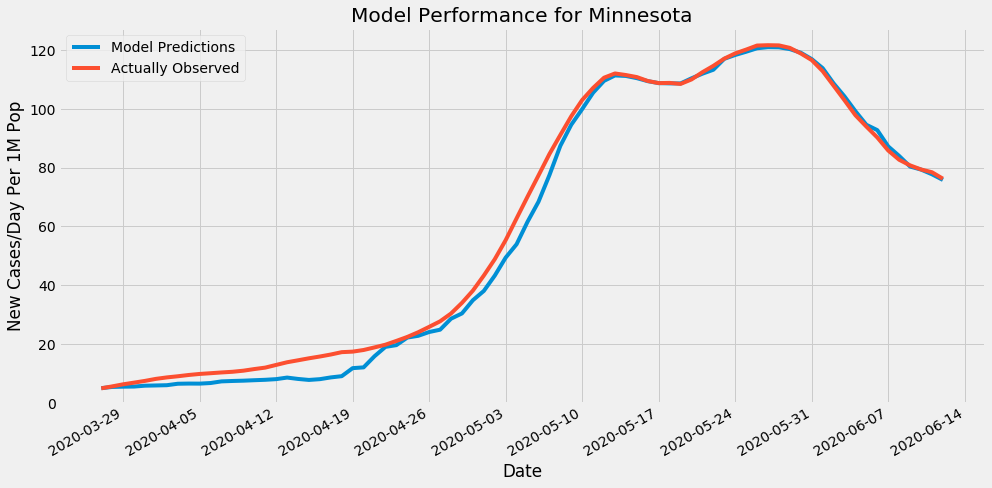

In [30]:
fig, ax = plt.subplots(figsize=(14, 7))
x = MN_ts_x['days_elapsed(t)']
ax.plot(x.apply(convert_to_date), rf_model.model.predict(MN_ts_x.drop('state(t)', axis = 1)), label='Model Predictions')
ax.plot(x.apply(convert_to_date), MN_ts_y, label='Actually Observed')
ax.set_ylim(0)
ax.legend()
ax.set_title('Model Performance for {}'.format('Minnesota'))
ax.set_xlabel('Date')
ax.set_ylabel('New Cases/Day Per 1M Pop')
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
fig.autofmt_xdate(rotation=30)
fig.tight_layout()
fig.savefig('images/MN_perf')

In [31]:
high_pred = generate_prediction_df(max_SD, MN_ts_x, MN_ts_y, predictions=21, rf = rf_model)
fig, ax = plt.subplots(figsize=(14, 7))
labels = ['High Social Distancing', 'Low Social Distancing']
x = high_pred[0]['days_elapsed(t)']
x.apply(lambda x: x + 88)
y = high_pred[1]

ax.plot(MN_ts_x['days_elapsed(t)'], MN_ts_y, label = 'Past Data', c = 'black')
ax.plot(x.values, y, label= 'High Social Distancing')

low_pred = generate_prediction_df(min_SD, MN_ts_x, MN_ts_y, predictions=21, rf=rf_model)
x = low_pred[0]['days_elapsed(t)']
y = low_pred[1]
# ax.plot(x[x >= 15], y[x >= 15], label='Low Social Distancing')

ax.legend()
ax.set_title('Future Predicted Daily New Cases'.format('Minnesota'))
ax.set_xlabel('Date')
ax.set_ylabel('New Cases/Day Per 1M Pop')
# ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
# fig.autofmt_xdate(rotation=30)
fig.tight_layout()

> /Users/jbud/Desktop/Galvanize/repos/Covid-19-Forecasting/src/Misc_functions.py(129)generate_prediction_df()
-> fill_diag_and_predictions = fill_diagonals(
(Pdb) c


ValueError: Number of features of the model must match the input. Model n_features is 30 and input n_features is 31 

In [29]:
covid_df = load_and_clean_data()
Similar_States_Init = Comparable_S

fig, ax = plt.subplots(figsize = (14, 7))
feat_importance = pd.DataFrame(State_Compile.get_feature_importances().T.iloc[:, -9:].values.flatten()).T
cols = State_Compile.get_feature_importances().T.iloc[:, -9:].columns.values
feat_importance.columns = [x.replace('_', ' ').replace('(t)', '').title() for x in cols]
feat_importance.sort_values(by =0, axis = 1, ascending = False, inplace = True)
colors = ['blue', 'grey', 'blue', 'blue', 'blue', 'blue', 'gray', 'grey', 'blue']

ax.bar(feat_importance.columns, feat_importance.values.flatten(), color = colors)
plt.yscale('log')
ax.set_title('Feature Importances for {}'.format(state))
ax.set_ylabel('Feature Importance')
fig.autofmt_xdate(rotation = 20)
fig.tight_layout()
fig.savefig('images/MN_Feat')

NameError: name 'Comparable_S' is not defined

In [32]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap
matplotlib.rcParams.update({'font.size': 18})
plt.style.use('fivethirtyeight')
plt.close('all')


In [33]:
State_Compile.get_feature_importances().T

driving(t)  workplaces(t)  days_elapsed(t)  parks(t)  residential(t)  \
0    0.005307       0.001048         0.001022  0.000765        0.000541   

   retail_and_recreation(t)  transit_stations(t)  grocery_and_pharmacy(t)  \
0                    0.0005             0.000346                 0.000311   

   pop_density(t)  
0        0.000088

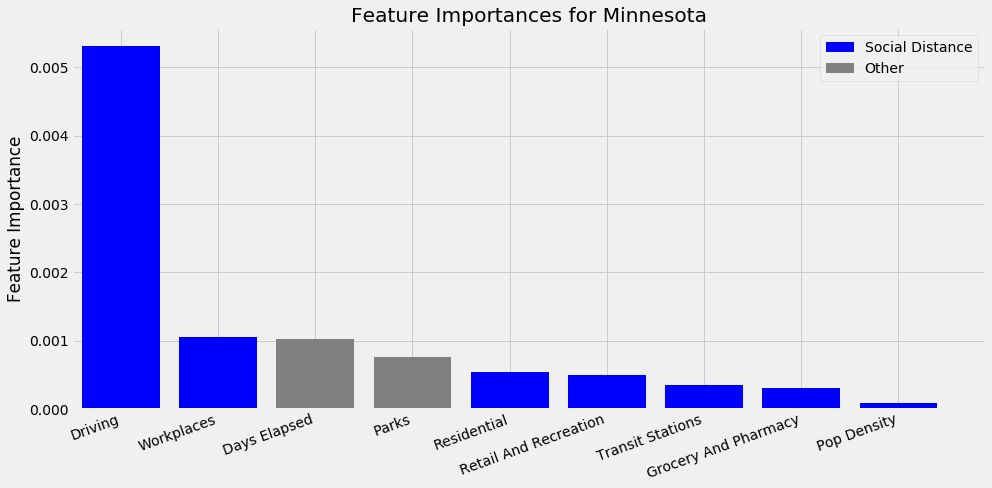

In [34]:
fig, ax = plt.subplots(figsize = (14, 7))
feat_importance = pd.DataFrame(State_Compile.get_feature_importances().T.iloc[:, -9:].values.flatten()).T
cols = State_Compile.get_feature_importances().T.iloc[:, -9:].columns.values
feat_importance.columns = [x.replace('_', ' ').replace('(t)', '').title() for x in cols]
colors = ['blue', 'blue', 'grey', 'grey', 'blue', 'blue', 'blue', 'blue', 'blue']
cols = feat_importance.columns
colorDict = {col: color for col, color in zip(cols, colors)}
feat_importance.sort_values(by =0, axis = 1, ascending = False, inplace = True)
colors = [colorDict[each] for each in feat_importance]
labels = ['Social Distancing', 'Other']
ax.bar(feat_importance.columns, feat_importance.values.flatten(), color = colors, label = 'Social Distance')
# plt.yscale('log')
ax.set_title('Feature Importances for {}'.format(state))
ax.bar([-1],[0.003], color = 'grey', label = 'Other')
ax.set_xlim(-0.5)
ax.set_ylabel('Feature Importance')
fig.autofmt_xdate(rotation = 20)
fig.tight_layout()
ax.legend()
fig.savefig('images/MN_Feat')

In [35]:
Recov_df = round(Similar_States.master_pop_density_df.loc[np.append(similar_states, state)], 1)
Recov_df.rename(columns = {'pop_density': 'People/Square Mile'}, inplace = True)
Recov_df.index.name = 'State'

In [36]:
Recov_df

People/Square Mile  Recovery Factor
State                                             
Colorado                     56.4              3.3
Iowa                         56.9              1.8
Vermont                      68.1              3.2
Minnesota                    71.6              1.7
West Virginia                74.0              2.6
Minnesota                    71.6              1.7

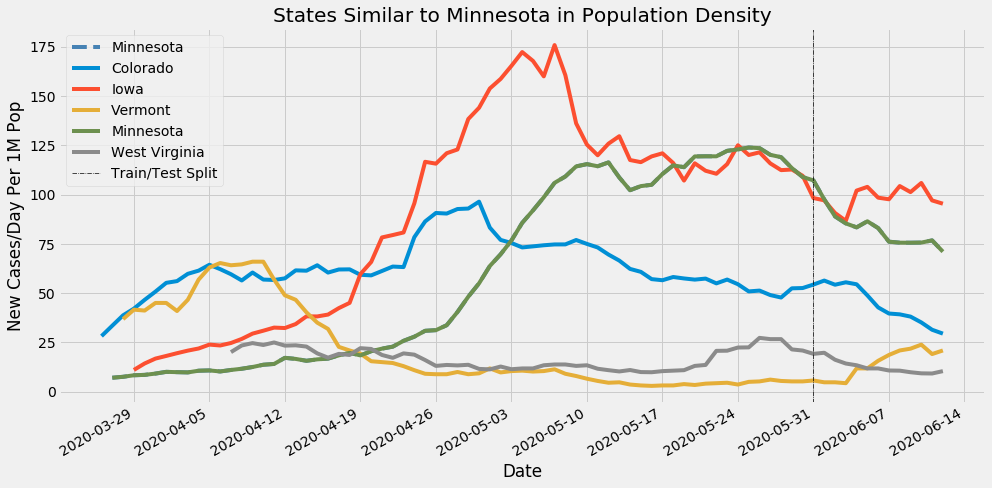

In [37]:
Prediction_Insights.plot_similar_states(save = 'images/SimilarTo{}'.format(state))

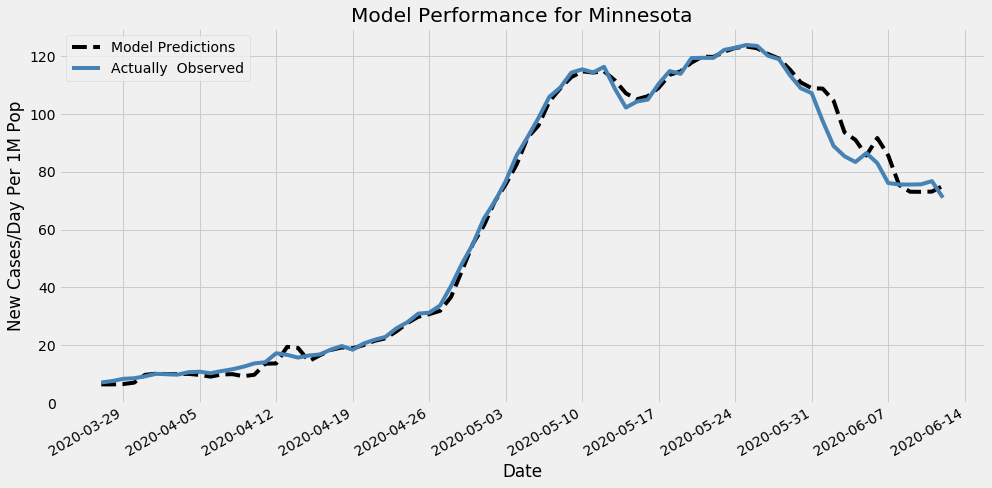

In [4]:
Prediction_Insights.plot_pred_vs_actual(save = 'images/ModelPerf{}'.format(state))

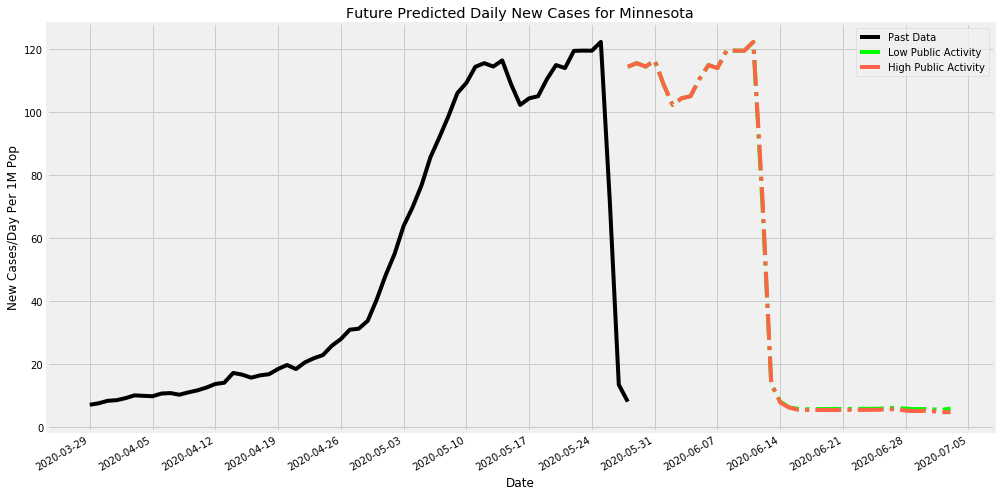

In [3]:
Prediction_Insights.forecast_to_future(save = 'images/forecast3for{}'.format(state))

In [7]:
SD_Table = Prediction_Insights.get_social_distancing_estimates(analysis = True)

In [8]:
round(SD_Table, 1)

Retail/Recreation %  Grocery/Pharmacy %  Parks %  Transit Stations %  \
                                                                             
High                 52.7                74.0     94.1                43.3   
Low                  93.9               117.0    229.9                96.1   

      Workplaces %  Residential %  Driving %  
                                              
High          50.1          119.4       55.8  
Low           72.7          108.6      124.7

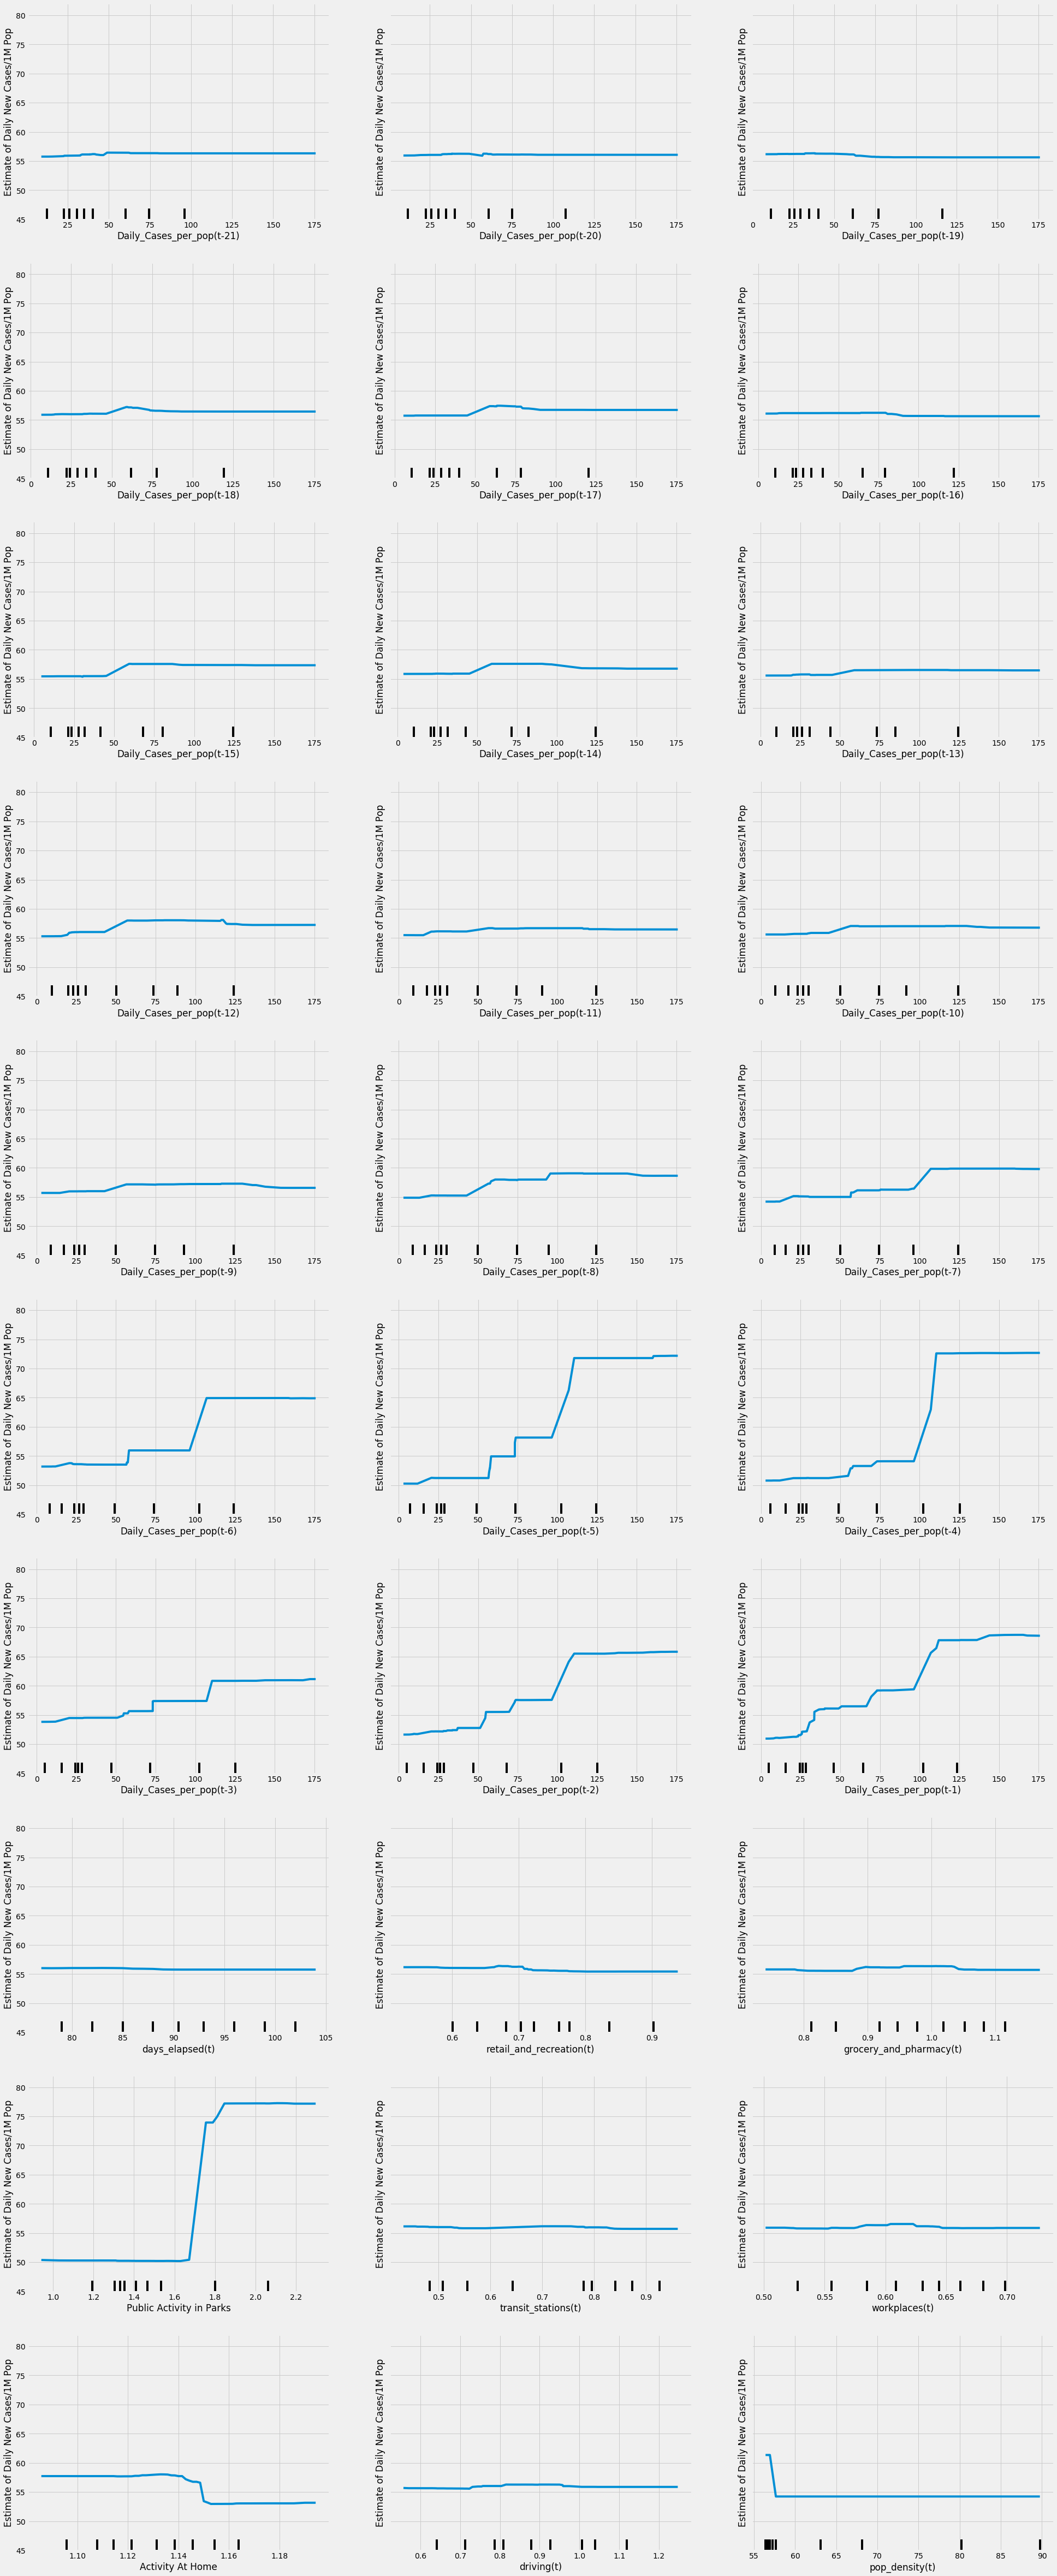

In [12]:
from sklearn.inspection import plot_partial_dependence
State_Compile.X.rename(columns = {'parks(t)': 'Public Activity in Parks', 'residential(t)': 'Activity At Home'}, inplace = True)
fig = plot_partial_dependence(State_Compile.rf.model, State_Compile.X, State_Compile.X.columns, grid_resolution = 500)
fig = plt.gcf()
axes = fig.get_axes()
for ax in axes:
    ax.set_ylim(45, 82)
    ax.set_ylabel('Estimate of Daily New Cases/1M Pop')
fig.set_figwidth(30)
fig.set_figheight(80)

# fig.subplots_adjust(wspace=0.4, hspace=0.3)

In [13]:
fig.savefig('images/MNPartialDep3', dpi = 300)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a5278a898>,
      dtype=object)

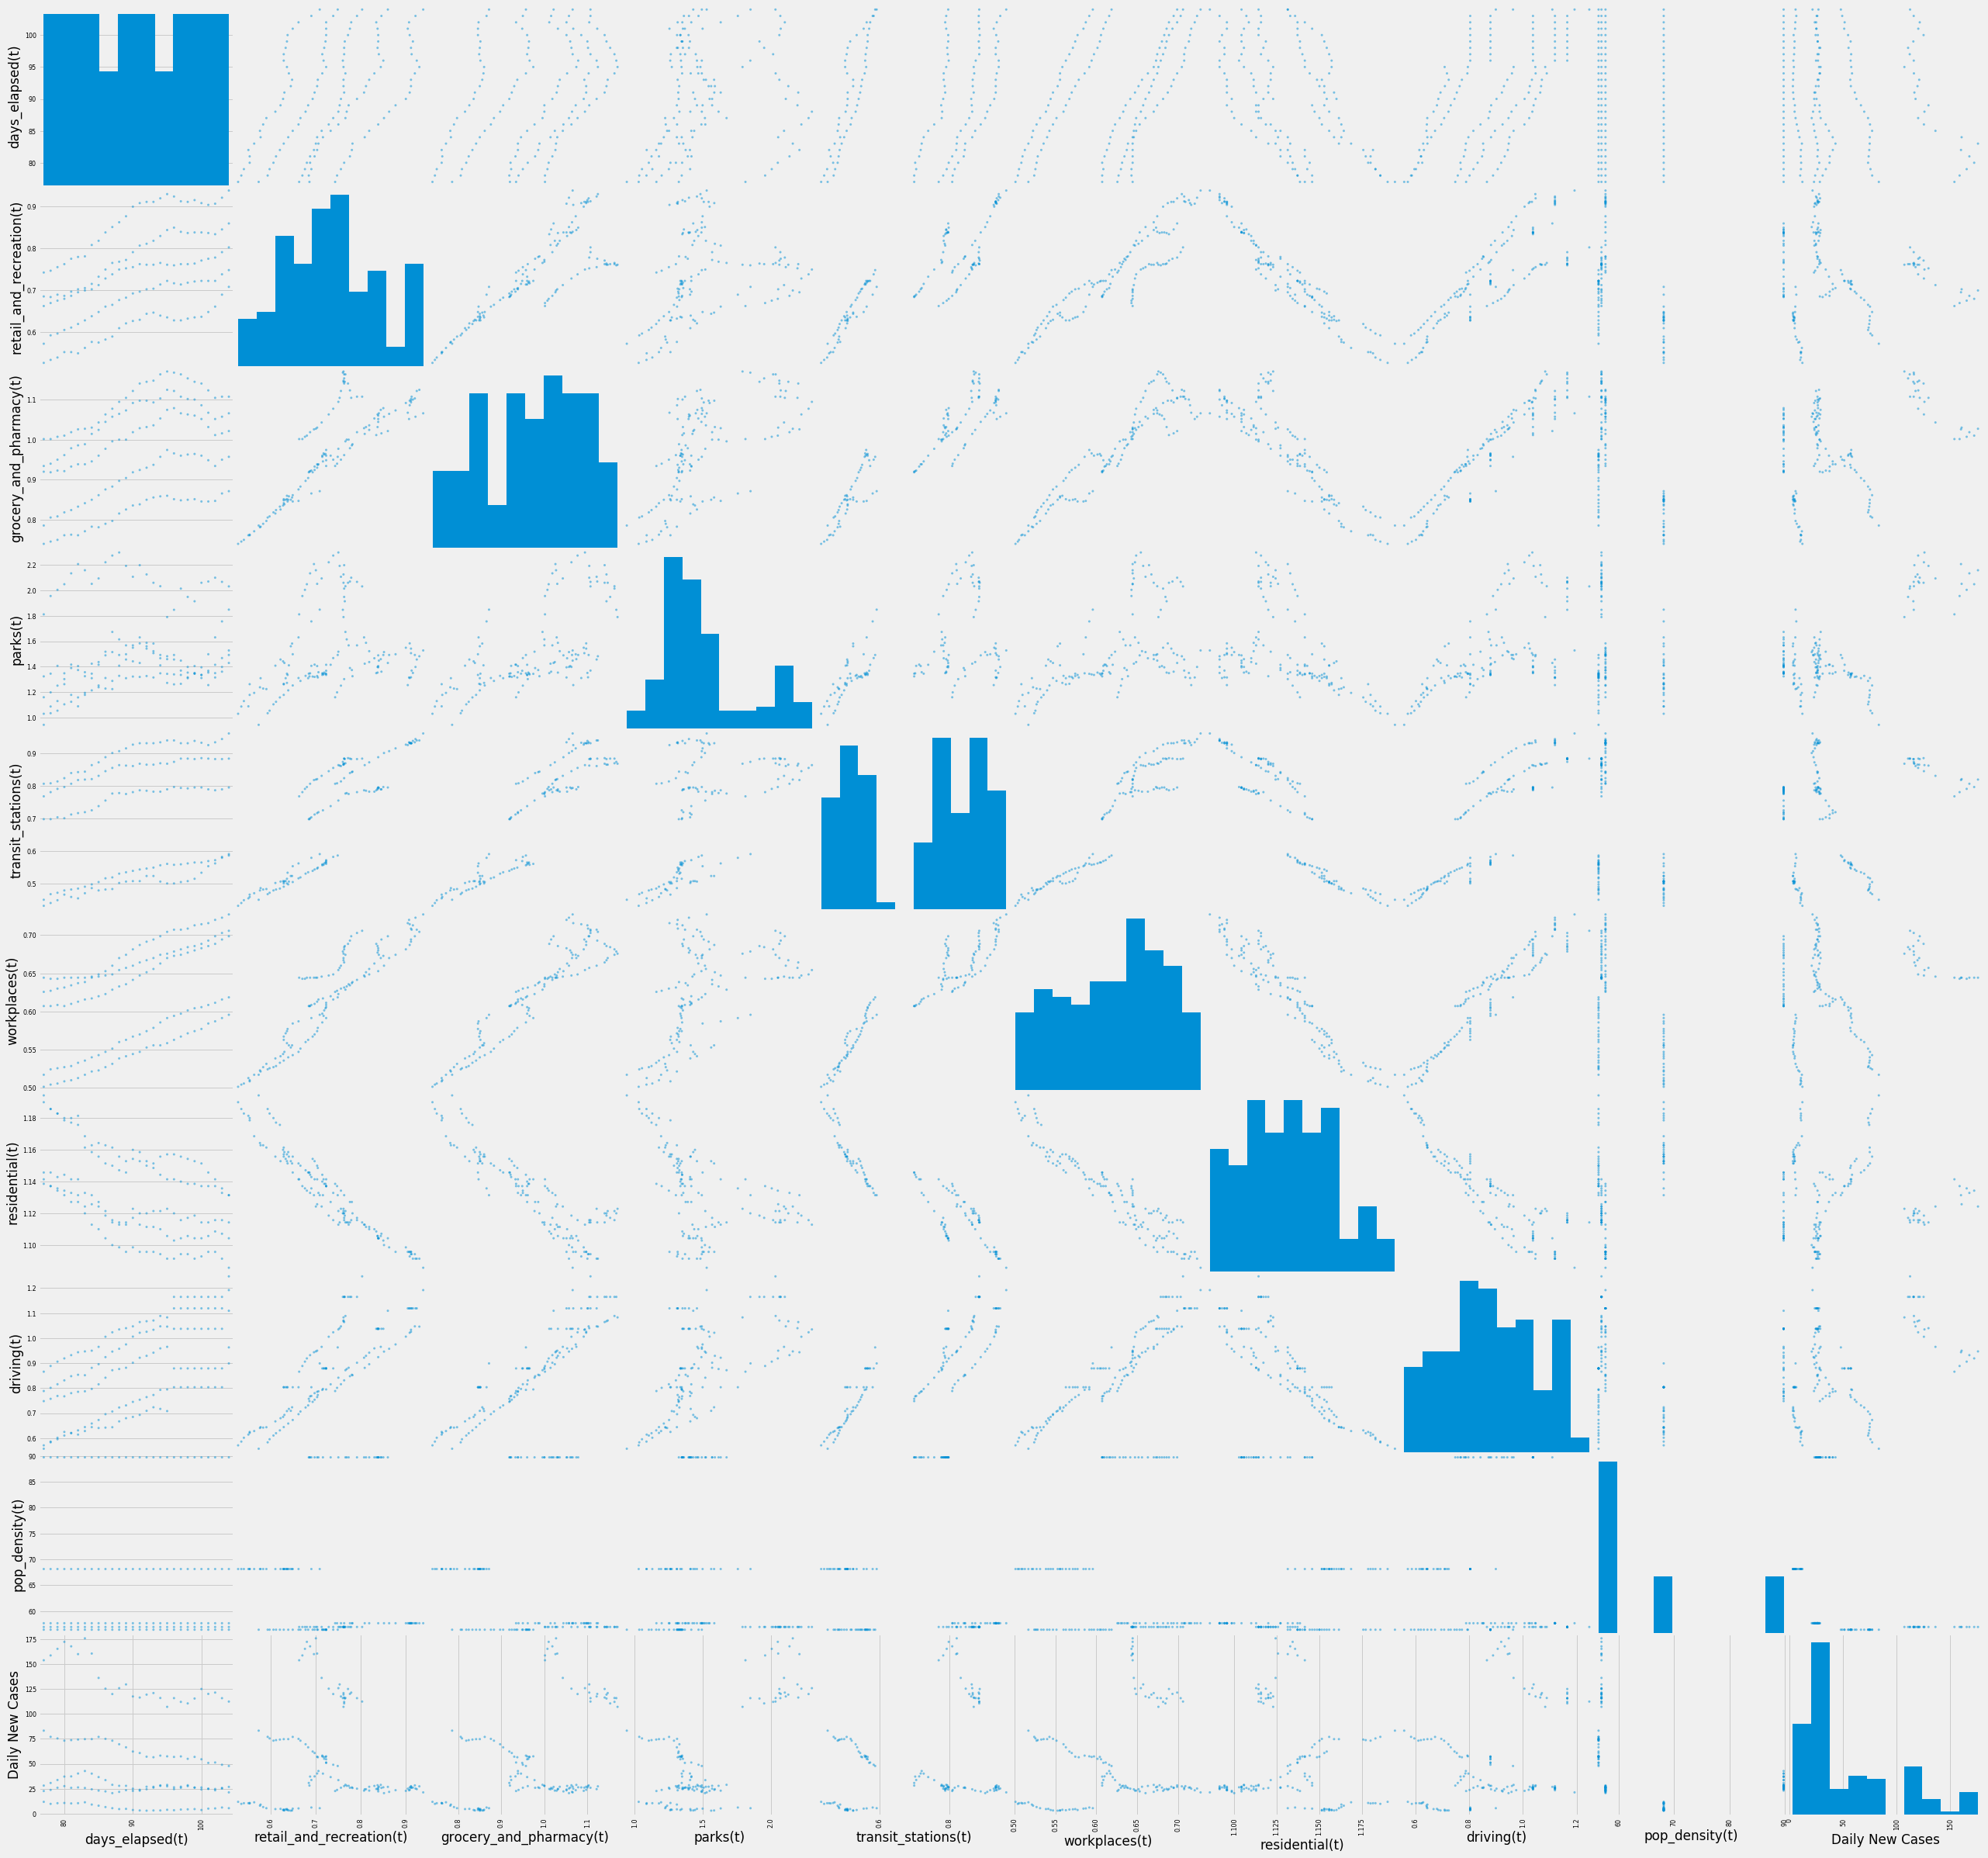

In [633]:
## from pandas.plotting import scatter_matrix
total = State_Compile.X.iloc[:,-9:].copy()
total['Daily New Cases'] = State_Compile.y
scatter_matrix(total, figsize = (40,40))

Text(0.5, 0.98, 'MN Social Distancing Features')

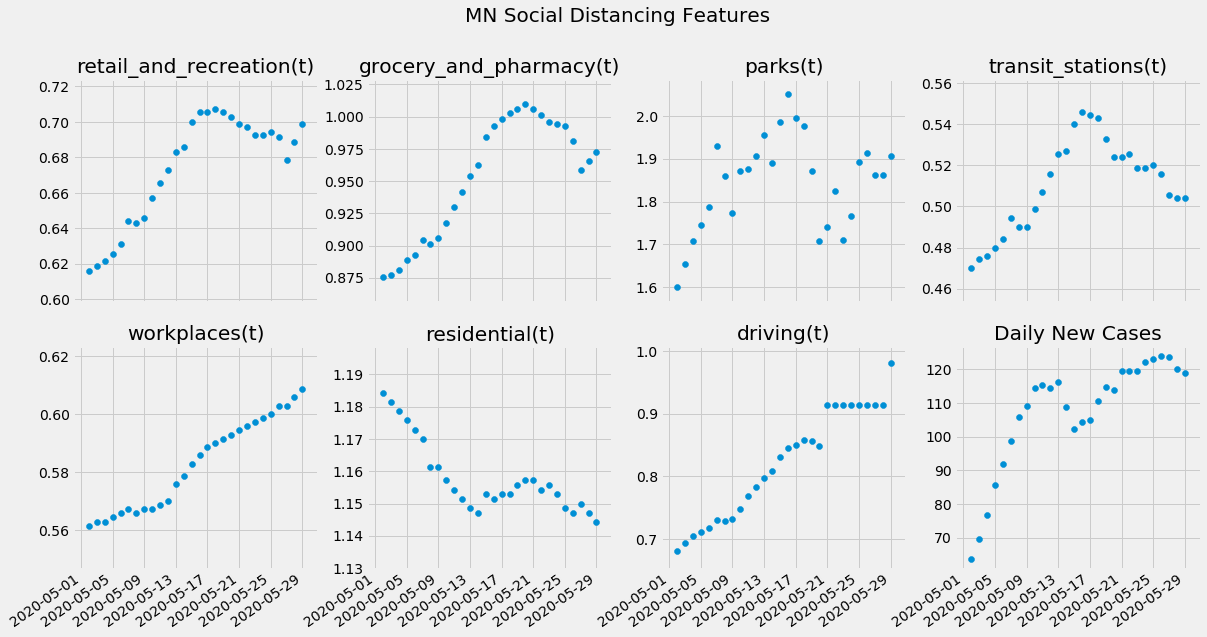

In [72]:
SD_time = Prediction_Insights.State_Analysis_X.iloc[:, -9:-1]
x = SD_time['days_elapsed(t)']
fig, axes = plt.subplots(2, 4, figsize = (18, 10))
for i, ax in enumerate(axes.flatten(), 1):
    try:
        ax.scatter(x.apply(convert_to_date), SD_time.iloc[:,i])
        ax.set_title(SD_time.columns[i])
    except:
        ax.scatter(x.apply(convert_to_date), Prediction_Insights.State_Analysis_y)
        ax.set_title('Daily New Cases')
    ax.set_xlim(convert_to_date(75), convert_to_date(106))
    
fig.autofmt_xdate(rotation = 35)
fig.suptitle("MN Social Distancing Features", fontsize=20)

In [74]:
fig.savefig('images/MN_SocialD', dpi = 300)

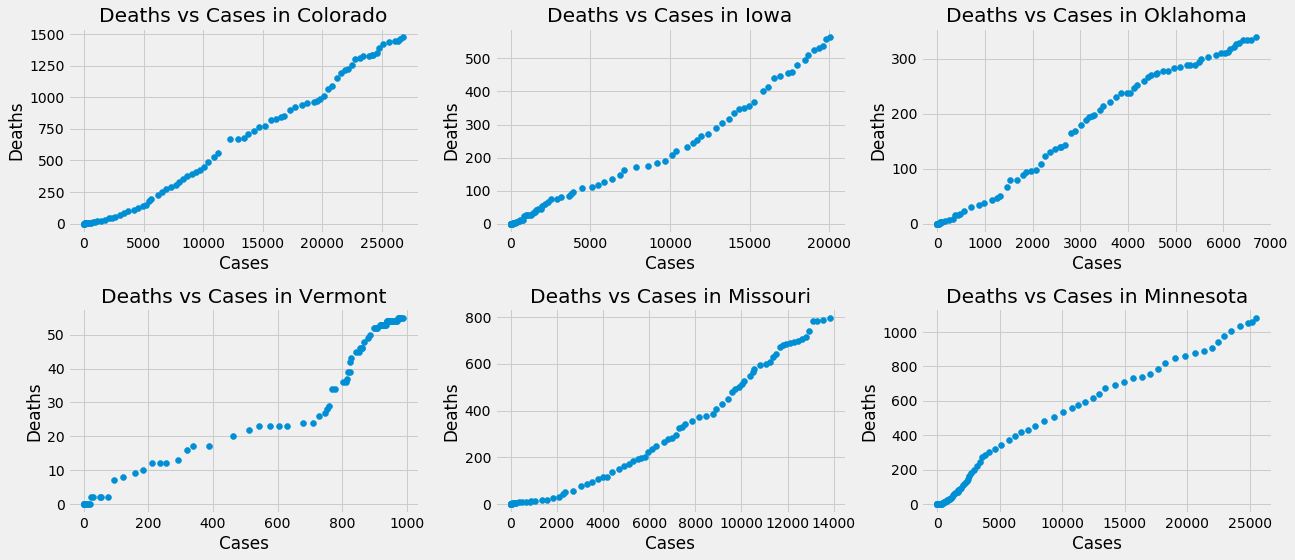

In [79]:
# Plot state deaths vs cases
def raw_state_data(states):
    covid_raw_df = pd.read_csv('data/covid-19-data/us-states.csv')
    state_raw_list = []
    for state in states:
        state_raw_list.append(covid_raw_df[covid_raw_df['state'] == state])
    return state_raw_list

fig, axes = plt.subplots(2, 3, figsize = (18,8))
similar_states = np.append(similar_states, 'Minnesota')
state_list = raw_state_data(similar_states)

for i, ax in enumerate(axes.flatten()):
    try:
        state_name = state_list[i]['state'].unique()[0]
        ax.scatter(state_list[i]['cases'], state_list[i]['deaths'])
        ax.set_title('Deaths vs Cases in {}'.format(state_name))
        ax.set_xlabel('Cases')
        ax.set_ylabel('Deaths')
    except:
        continue
fig.tight_layout()
# Mostly linear trend between cases and deaths
fig.savefig('images/DeathVsCases', dpi = 300)

In [8]:
state = 'Colorado'

covid_df = load_and_clean_data()
Similar_States_Init = Comparable_States()
Similar_States_Init.make_master_pop_dens_df()
sim_states_df = Similar_States_Init.get_similar_states(
    state_to_predict=state, recovery_factor_min= 2, pop_density_tolerance=25)
similar_states = sim_states_df.index.values
State_Compile = Combined_State_Analysis(similar_states, print_err=True)
State_Compile.get_feature_importances().T
print("The Most similar states to {} that meet the comparable parameters are: {}. These will be used to predict for {}.".format(
    state, similar_states, state))

Prediction_Insights = Predictions(covid_df, state, similar_states, State_Compile)

rmse: 6.811271993116912
The Most similar states to Colorado that meet the comparable parameters are: ['Kansas' 'Oregon' 'Colorado' 'Vermont']. These will be used to predict for Colorado.


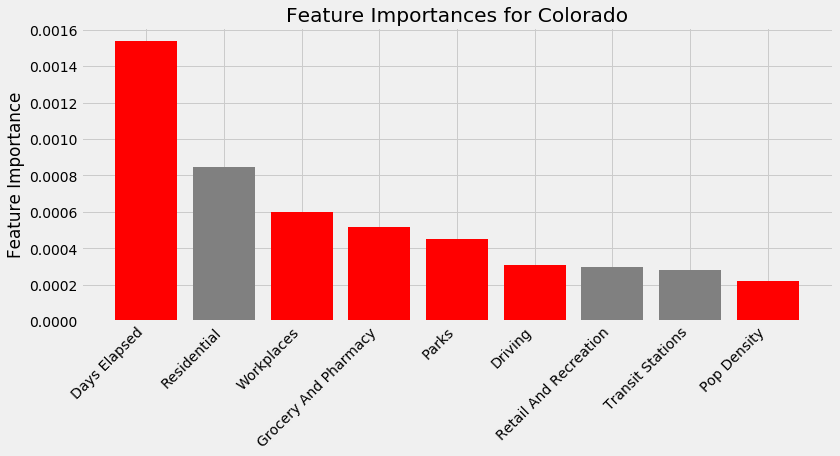

In [15]:
fig, ax = plt.subplots(figsize = (12, 6))
feat_importance = pd.DataFrame(State_Compile.get_feature_importances().T.iloc[:, -9:].values.flatten()).T
cols = State_Compile.get_feature_importances().T.iloc[:, -9:].columns.values
feat_importance.columns = [x.replace('_', ' ').replace('(t)', '').title() for x in cols]
feat_importance.sort_values(by =0, axis = 1, ascending = False, inplace = True)
colors = ['red', 'grey', 'red', 'red', 'red', 'red', 'grey', 'grey']

ax.bar(feat_importance.columns, feat_importance.values.flatten(), color = colors)
ax.set_title('Feature Importances for {}'.format(state))
ax.set_ylabel('Feature Importance')
fig.autofmt_xdate(rotation = 45)
fig.savefig('images/MN_Feat')

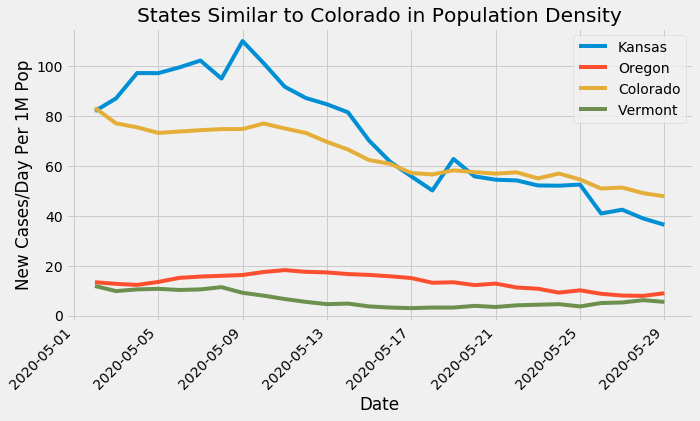

In [10]:
import matplotlib.pyplot as plt
Prediction_Insights.plot_similar_states(save = 'images/SimilarTo{}'.format(state))

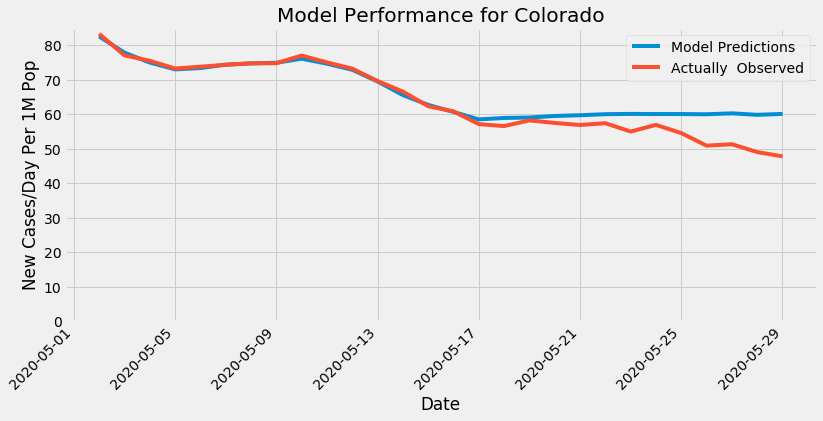

In [11]:
Prediction_Insights.plot_pred_vs_actual(save = 'images/ModelPerf{}'.format(state))

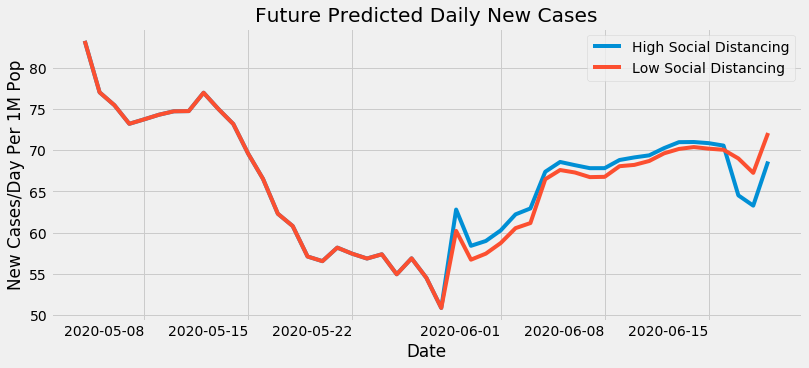

In [12]:
Prediction_Insights.forecast_to_future(save = 'images/forecastfor{}'.format(state))

In [13]:
SD_Table = Prediction_Insights.get_social_distancing_estimates(analysis = True)

In [14]:
SD_Table

Retail/Recreation %  Grocery/Pharmacy %  Parks %  Transit Stations %  \
                                                                             
Low                 52.71               74.00    94.14               43.29   
High                83.57              103.57   217.71               93.43   

      Workplaces %  Residential %  Driving %  
                                              
Low          50.14         119.43      55.75  
High         70.14         110.00     117.09

In [57]:
state = 'California'

covid_df = load_and_clean_data()
Similar_States_Init = Comparable_States()
Similar_States_Init.make_master_pop_dens_df()
sim_states_df = Similar_States_Init.get_similar_states(
    state_to_predict=state, recovery_factor_min= 1.5, pop_density_tolerance= 100)
similar_states = sim_states_df.index.values
State_Compile = Combined_State_Analysis(similar_states, print_err=True)
State_Compile.get_feature_importances().T
print("The Most similar states to {} that meet the comparable parameters are: {}. These will be used to predict for {}.".format(
    state, similar_states, state))

Prediction_Insights = Predictions(covid_df, state, similar_states, State_Compile)

rmse: 7.313866980494069
The Most similar states to California that meet the comparable parameters are: ['Michigan' 'Indiana' 'Hawaii' 'Pennsylvania' 'Ohio']. These will be used to predict for California.


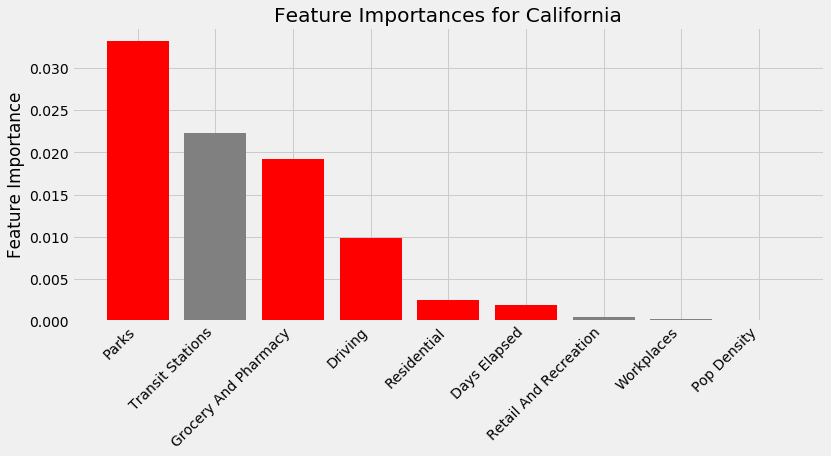

In [58]:
fig, ax = plt.subplots(figsize = (12, 6))
feat_importance = pd.DataFrame(State_Compile.get_feature_importances().T.iloc[:, -9:].values.flatten()).T
cols = State_Compile.get_feature_importances().T.iloc[:, -9:].columns.values
feat_importance.columns = [x.replace('_', ' ').replace('(t)', '').title() for x in cols]
feat_importance.sort_values(by =0, axis = 1, ascending = False, inplace = True)
colors = ['red', 'grey', 'red', 'red', 'red', 'red', 'grey', 'grey']

ax.bar(feat_importance.columns, feat_importance.values.flatten(), color = colors)
ax.set_title('Feature Importances for {}'.format(state))
ax.set_ylabel('Feature Importance')
fig.autofmt_xdate(rotation = 45)
# fig.savefig('images/MN_Feat')

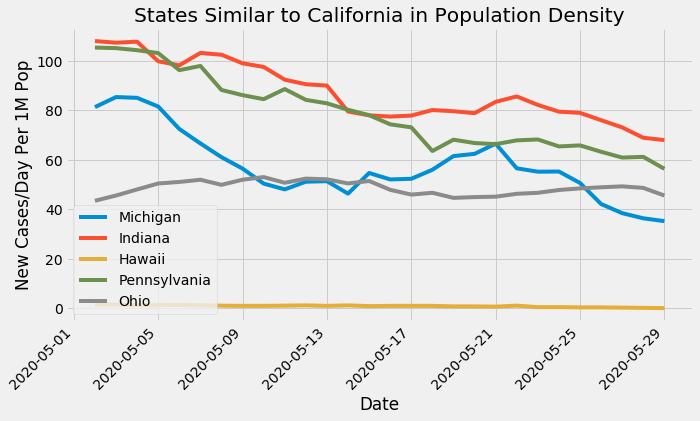

In [59]:
import matplotlib.pyplot as plt
Prediction_Insights.plot_similar_states(save = 'images/SimilarTo{}'.format(state))

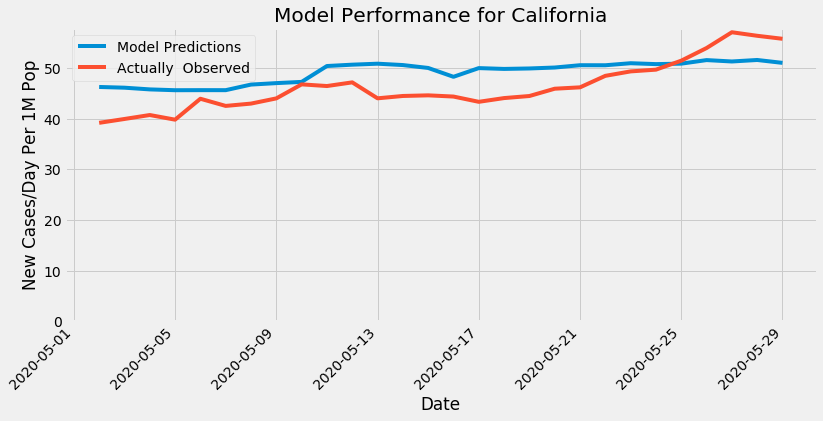

In [60]:
Prediction_Insights.plot_pred_vs_actual(save = 'images/ModelPerf{}'.format(state))

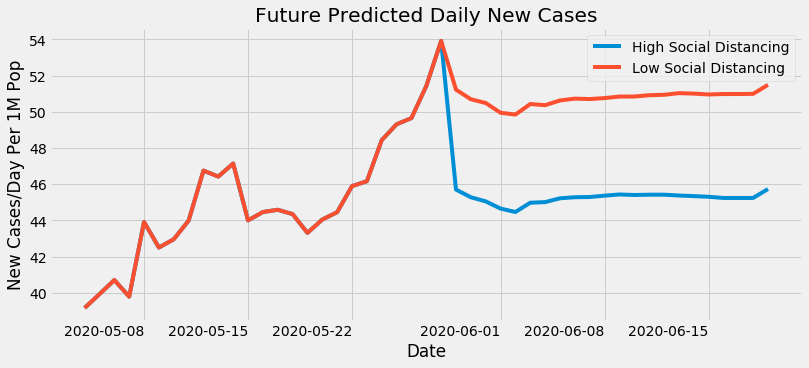

In [61]:
Prediction_Insights.forecast_to_future(save = 'images/forecastfor{}'.format(state))

In [62]:
SD_Table = Prediction_Insights.get_social_distancing_estimates(analysis = True)

In [63]:
SD_Table

Retail/Recreation %  Grocery/Pharmacy %  Parks %  Transit Stations %  \
                                                                             
High                47.29               69.86    36.14               30.43   
Low                 85.29              103.71   211.00               88.29   

      Workplaces %  Residential %  Driving %  
                                              
High         46.00         121.86      32.89  
Low          68.57         111.57     116.06

In [182]:
state = 'Texas'

covid_df = load_and_clean_data()
Similar_States_Init = Comparable_States()
Similar_States_Init.make_master_pop_dens_df()
sim_states_df = Similar_States_Init.get_similar_states(
    state_to_predict=state, recovery_factor_min= 1.0, pop_density_tolerance= 10)
similar_states = sim_states_df.index.values
State_Compile = Combined_State_Analysis(similar_states, print_err=True)
State_Compile.get_feature_importances().T
print("The Most similar states to {} that meet the comparable parameters are: {}. These will be used to predict for {}.".format(
    state, similar_states, state))

Prediction_Insights = Predictions(covid_df, state, similar_states, State_Compile)

rmse: 9.89940331291399
The Most similar states to Texas that meet the comparable parameters are: ['Louisiana' 'Texas' 'Kentucky' 'Washington']. These will be used to predict for Texas.


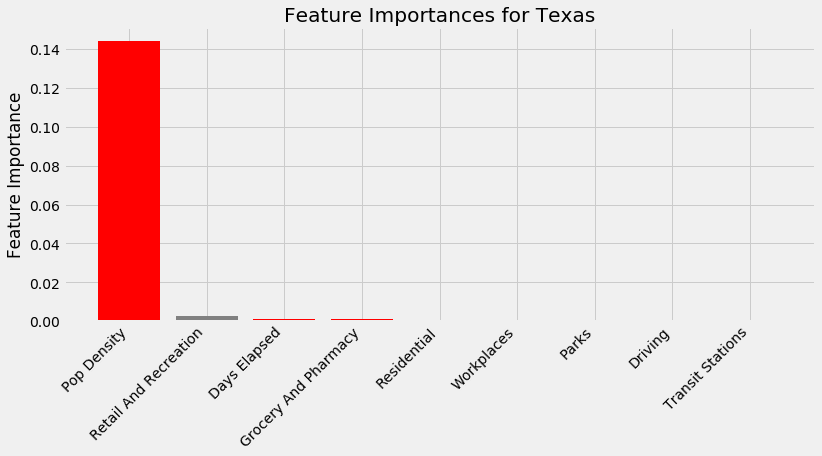

In [183]:
fig, ax = plt.subplots(figsize = (12, 6))
feat_importance = pd.DataFrame(State_Compile.get_feature_importances().T.iloc[:, -9:].values.flatten()).T
cols = State_Compile.get_feature_importances().T.iloc[:, -9:].columns.values
feat_importance.columns = [x.replace('_', ' ').replace('(t)', '').title() for x in cols]
feat_importance.sort_values(by =0, axis = 1, ascending = False, inplace = True)
colors = ['red', 'grey', 'red', 'red', 'red', 'red', 'grey', 'grey']

ax.bar(feat_importance.columns, feat_importance.values.flatten(), color = colors)
ax.set_title('Feature Importances for {}'.format(state))
ax.set_ylabel('Feature Importance')
fig.autofmt_xdate(rotation = 45)
# fig.savefig('images/MN_Feat')

In [15]:
for each in enumerate(np.array(['saf','fdasfa'])):
    print(each)

(0, 'saf')
(1, 'fdasfa')


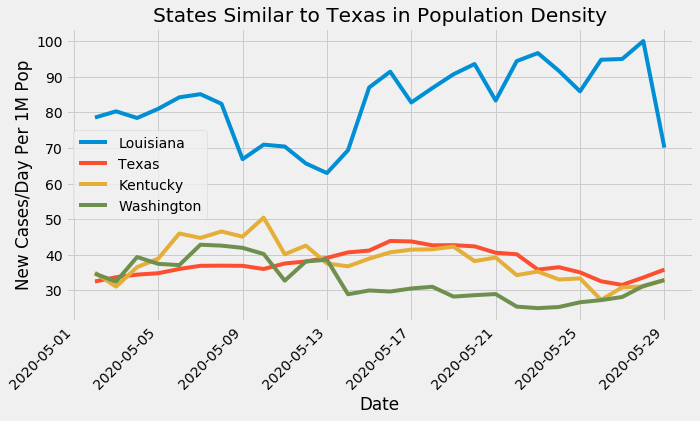

In [184]:
import matplotlib.pyplot as plt
Prediction_Insights.plot_similar_states(save = 'images/SimilarTo{}'.format(state))

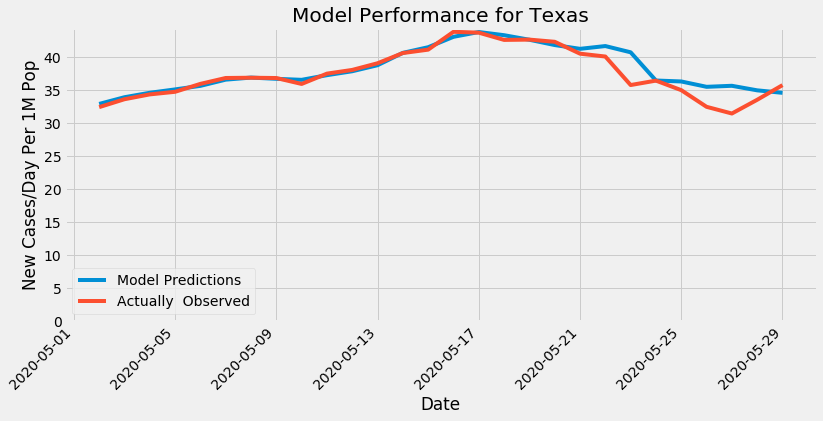

In [185]:
Prediction_Insights.plot_pred_vs_actual(save = 'images/ModelPerf{}'.format(state))

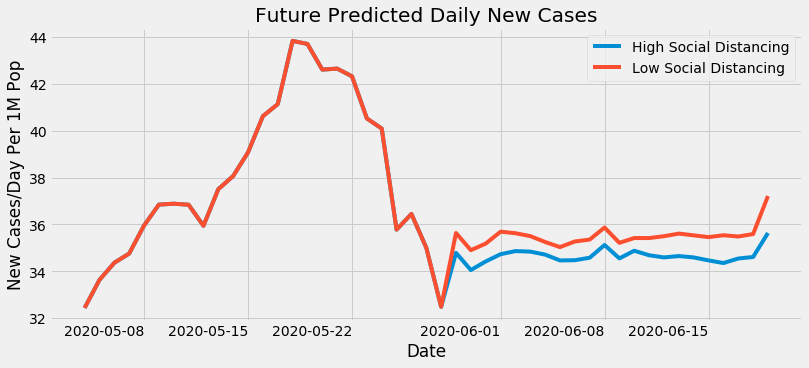

In [186]:
Prediction_Insights.forecast_to_future(save = 'images/forecastfor{}'.format(state))

In [187]:
SD_Table = Prediction_Insights.get_social_distancing_estimates(analysis = True)

In [188]:
SD_Table

Retail/Recreation %  Grocery/Pharmacy %  Parks %  Transit Stations %  \
                                                                             
High                60.86               84.29    76.00               47.29   
Low                 79.43              106.71   172.43               81.14   

      Workplaces %  Residential %  Driving %  
                                              
High         50.57         118.14      58.23  
Low          70.00         111.14     114.89

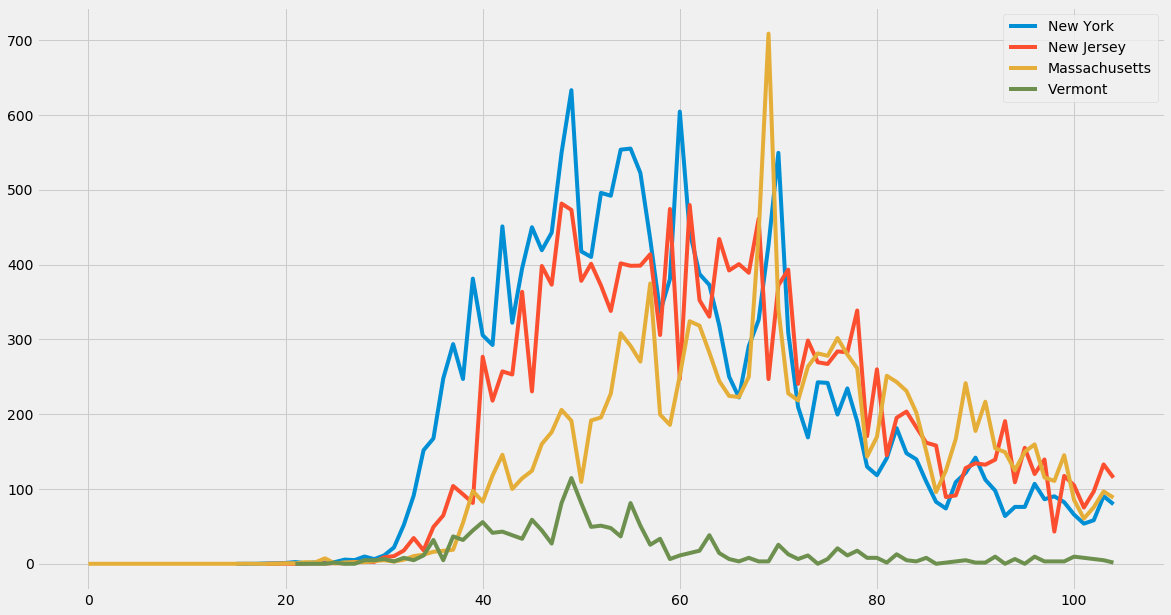

In [611]:
def plot_state(st, type = 'line', label = None):
    st_df = covid_df[covid_df['state'] == st]
    if type == 'line':
        plt.plot(st_df['days_elapsed'], st_df['New_Cases_per_pop'], label = label)
    else:
        plt.scatter(st_df['days_elapsed'], st_df['New_Cases_per_pop'], label = label)
    st_df = st_df.drop(['state', 'pop_density'], axis = 1)
    st_df.index.name = st
    return st_df

fig, axes = plt.subplots(figsize = (18, 10))
plt_type = 'line'
NY_df = plot_state('New York', type = plt_type, label = 'New York')
NJ_df = plot_state('New Jersey', type = plt_type, label = 'New Jersey')
MA_df = plot_state('Massachusetts', type = plt_type, label = 'Massachusetts')
VM_df = plot_state('Vermont', type = plt_type, label = 'Vermont')
plt.legend()

In [140]:
state = 'Wisconsin'

covid_df = load_and_clean_data()
Similar_States_Init = Comparable_States()
Similar_States_Init.make_master_pop_dens_df()
sim_states_df = Similar_States_Init.get_similar_states(
    state_to_predict=state, recovery_factor_min= 1, pop_density_tolerance=60)
similar_states = sim_states_df.index.values
State_Compile = Combined_State_Analysis(similar_states, print_err=True)
State_Compile.get_feature_importances().T
print("The Most similar states to {} that meet the comparable parameters are: {}. These will be used to predict for {}.".format(
    state, similar_states, state))

Prediction_Insights = Predictions(covid_df, state, similar_states, State_Compile)

rmse: 5.6658043242474125
The Most similar states to Wisconsin that meet the comparable parameters are: ['Colorado' 'Iowa' 'Oklahoma' 'Arkansas' 'Arizona' 'Vermont' 'Minnesota'
 'West Virginia' 'Missouri' 'Alabama' 'Louisiana' 'Texas' 'Kentucky'
 'Washington' 'New Hampshire' 'Tennessee']. These will be used to predict for Wisconsin.


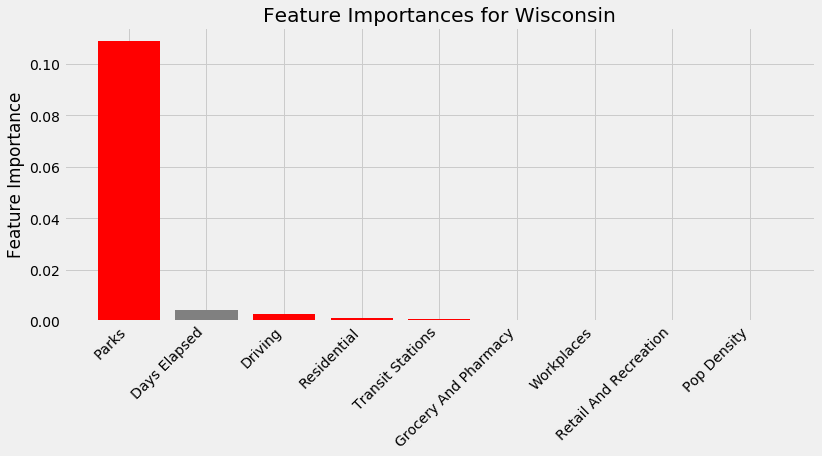

In [141]:
fig, ax = plt.subplots(figsize = (12, 6))
feat_importance = pd.DataFrame(State_Compile.get_feature_importances().T.iloc[:, -9:].values.flatten()).T
cols = State_Compile.get_feature_importances().T.iloc[:, -9:].columns.values
feat_importance.columns = [x.replace('_', ' ').replace('(t)', '').title() for x in cols]
feat_importance.sort_values(by =0, axis = 1, ascending = False, inplace = True)
colors = ['red', 'grey', 'red', 'red', 'red', 'red', 'grey', 'grey']

ax.bar(feat_importance.columns, feat_importance.values.flatten(), color = colors)
ax.set_title('Feature Importances for {}'.format(state))
ax.set_ylabel('Feature Importance')
fig.autofmt_xdate(rotation = 45)
# fig.savefig('images/MN_Feat')

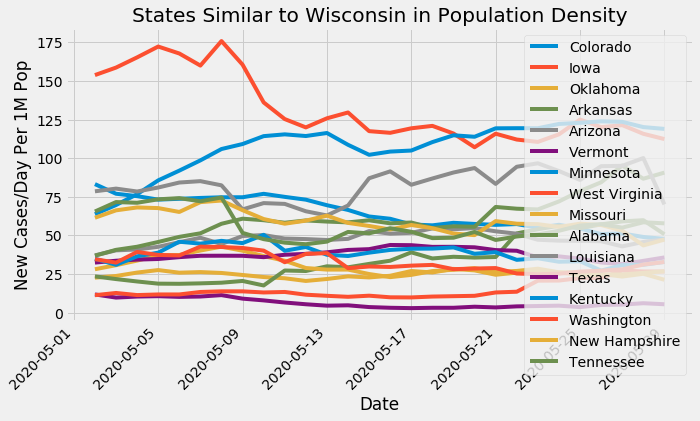

In [142]:
import matplotlib.pyplot as plt
Prediction_Insights.plot_similar_states(save = 'images/SimilarTo{}'.format(state))

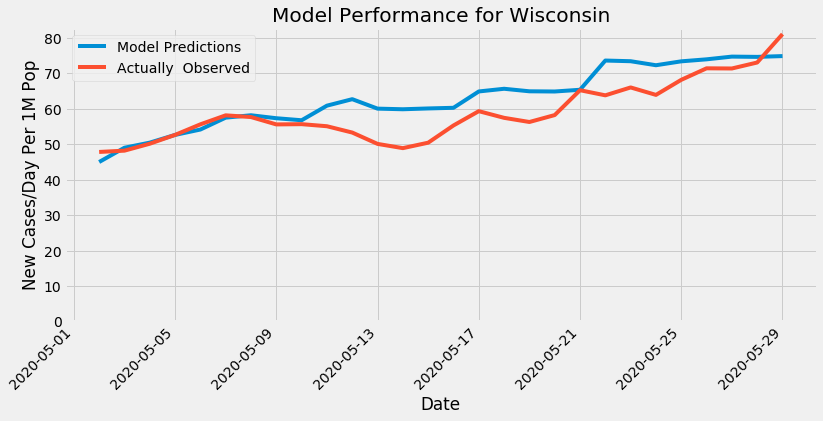

In [143]:
Prediction_Insights.plot_pred_vs_actual(save = 'images/ModelPerf{}'.format(state))

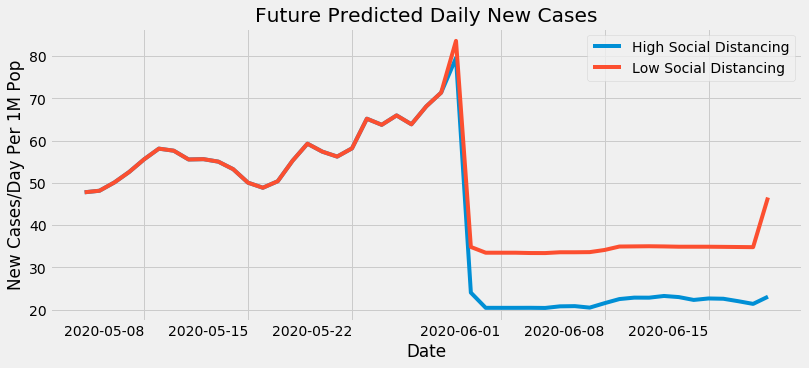

In [144]:
Prediction_Insights.forecast_to_future(save = 'images/forecastfor{}'.format(state))

In [83]:
SD_Table = Prediction_Insights.get_social_distancing_estimates(analysis = True)

In [84]:
SD_Table

Retail/Recreation %  Grocery/Pharmacy %  Parks %  Transit Stations %  \
                                                                             
High                50.00                74.0    78.29               43.29   
Low                 83.57               105.0   217.71               93.43   

      Workplaces %  Residential %  Driving %  
                                              
High         46.00         121.86      57.08  
Low          70.14         110.00     117.09

In [58]:
round(Similar_States_Init.make_master_pop_dens_df(), 2)

pop_density  Recovery Factor
state                                       
Alaska                 1.29             3.14
Wyoming                5.84             2.19
Montana                7.47            17.17
North Dakota          11.04             2.18
South Dakota          11.91             1.55
New Mexico            17.29             1.35
Idaho                 22.10             1.75
Nebraska              25.42             1.63
Nevada                28.60             1.26
Kansas                35.60             3.02
Utah                  39.94             1.11
Maine                 43.63             1.18
Oregon                44.81             2.04
Colorado              56.40             2.02
Iowa                  56.93             1.56
Oklahoma              57.65             1.37
Arkansas              58.40             1.18
Mississippi           63.71             1.00
Arizona               64.95             1.16
Vermont               68.14            12.08
Minnesota             71.59             1.04
West Virginia         73.97             1.02
Missouri              89.75             1.59
Alabama               96.92             1.05
Louisiana            107.52             3.93
Wisconsin            108.05             1.00
Texas                112.82             1.23
Kentucky             113.96             1.53
Washington           117.33             1.63
New Hampshire        153.16             1.54
Tennessee            167.27             1.29
South Carolina       173.32             1.03
Michigan             177.67             4.03
Georgia              186.67             1.34
Indiana              188.28             1.59
North Carolina       218.27             1.04
Virginia             218.44             1.01
Hawaii               219.94          1476.42
Illinois             228.02             1.37
California           256.37             1.02
Pennsylvania         286.54             2.31
Ohio                 287.50             1.72
Florida              410.13             1.67
New York             412.52             6.75
Delaware             504.31             2.09
Maryland             626.67             1.20
Connecticut          735.87             3.28
Massachusetts        894.44             3.60
Rhode Island        1021.43             2.96
New Jersey          1215.20             3.92

In [33]:
covid_df = load_and_clean_data()
covid_df = replace

In [6]:
state_list = ['Minnesota', 'Iowa', 'Colorado', 'Missouri', 'Oklahoma', 'Vermont']

Text(0, 0.5, 'Daily New Cases/ 1 M Pop')

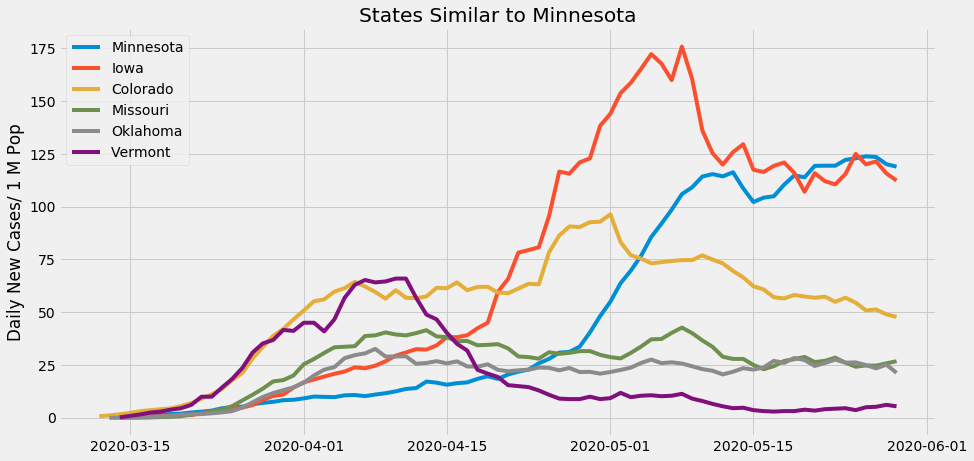

In [9]:
fig, ax = plt.subplots(figsize = (14, 7))
for each in state_list:
    state_df = get_moving_avg_df(covid_df, each, threshold = 0, days_threshold = 0)
    ax.plot(state_df['days_elapsed'].apply(convert_to_date), state_df['Daily_Cases_per_pop'], label = each)
ax.legend()
ax.set_xlabel('')
ax.set_title('States Similar to Minnesota')
ax.set_ylabel('Daily New Cases/ 1 M Pop')

In [10]:
fig.savefig('images/FullDataSetLikeMN')

In [183]:
state_X = Prediction_Insights.State_Analysis_X.copy()
start = 22

In [184]:
state_X.loc[start:, :'Daily_Cases_per_pop(t-1)'] = 0

In [185]:
y_pred = Prediction_Insights.State_Analysis_y.loc[:start-2]

In [186]:
n_rows = state_X.shape[0]
row_start = state_X.shape[0] - state_X[state_X['Daily_Cases_per_pop(t-1)'] == 0].count()[0]
col_start = 20
new_preds = list(y_pred.values)
state_X.iloc[row_start, col_start] = y_pred.values[-1]

IndexError: index -1 is out of bounds for axis 0 with size 0

In [187]:
for row in range(row_start, n_rows):
    for col in range(col_start - 1, -1, -1):
        state_X.iloc[row, col] = state_X.iloc[row - 1, col + 1]

In [188]:
def fill_diagonals(df, preds, model, start_row=31, n_interval=21):
    '''
    Used to populate time lagged observations - diagonal on matrix
    '''
    df.fillna(0, inplace=True)
    n_rows = df.shape[0]
    new_preds = list(preds.values)
    for row in range(start_row, n_rows)[:]:
        new_pred = model.predict(df[row:row + 1])[0]
        new_preds.append(new_pred)
        j = 0
        for col in range(n_interval-1, 0, -1):
            try:
                if df.iloc[row + j, col] == 0:
                    df.iloc[row + j, col] = new_pred
                j += 1
            except:
                continue
    new_pred = model.predict(df[-1:-2:-1])[0]
    new_preds.append(new_pred)
    return df, new_preds

In [189]:
fill_diag_and_predictions = fill_diagonals(
    state_X, y_pred.loc[:start + 1], State_Compile.rf.model, start_row=row_start, n_interval=21)
pred_df = fill_diag_and_predictions[0]
pred_y = fill_diag_and_predictions[1][-pred_df.shape[0]:]

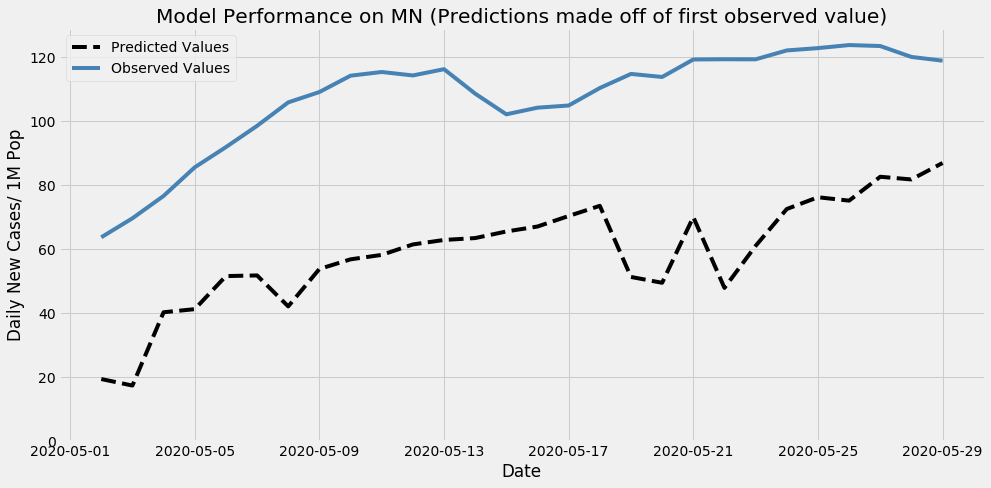

In [190]:
fig, axes = plt.subplots(figsize = (14, 7))

axes.plot(pred_df['days_elapsed(t)'].apply(convert_to_date), pred_y, label = 'Predicted Values', c = 'black', ls = '--')
axes.plot(Prediction_Insights.State_Analysis_X['days_elapsed(t)'].apply(convert_to_date), Prediction_Insights.State_Analysis_y, label = 'Observed Values', c = 'steelblue')
axes.set_ylim(0)
axes.set_xlabel('Date')
axes.set_ylabel('Daily New Cases/ 1M Pop')
axes.set_title("Model Performance on MN (Predictions made off of first observed value)")
axes.legend()
fig.tight_layout()

In [79]:
fig.savefig('images/MNmodelPerf')

In [55]:
Prediction_Insights.State_Analysis_X

Daily_Cases_per_pop(t-21)  Daily_Cases_per_pop(t-20)  \
Minnesota                                                         
21                         13.682600                  14.083555   
22                         14.083555                  17.190959   
23                         17.190959                  16.639645   
24                         16.639645                  15.687376   
25                         15.687376                  16.414108   
26                         16.414108                  16.790003   
27                         16.790003                  18.443944   
28                         18.443944                  19.696929   
29                         19.696929                  18.418884   
30                         18.418884                  20.548959   
31                         20.548959                  21.852064   
32                         21.852064                  22.854452   
33                         22.854452                  25.811498   
34                         25.811498                  27.916513   
35                         27.916513                  30.898618   
36                         30.898618                  31.224394   
37                         31.224394                  33.730365   
38                         33.730365                  40.446367   
39                         40.446367                  48.189816   
40                         48.189816                  54.980996   
41                         54.980996                  63.776953   
42                         63.776953                  69.716104   
43                         69.716104                  76.707762   
44                         76.707762                  85.654077   
45                         85.654077                  91.969123   
46                         91.969123                  98.609946   
47                         98.609946                 105.952440   
48                        105.952440                 109.185142   

           Daily_Cases_per_pop(t-19)  Daily_Cases_per_pop(t-18)  \
Minnesota                                                         
21                         17.190959                  16.639645   
22                         16.639645                  15.687376   
23                         15.687376                  16.414108   
24                         16.414108                  16.790003   
25                         16.790003                  18.443944   
26                         18.443944                  19.696929   
27                         19.696929                  18.418884   
28                         18.418884                  20.548959   
29                         20.548959                  21.852064   
30                         21.852064                  22.854452   
31                         22.854452                  25.811498   
32                         25.811498                  27.916513   
33                         27.916513                  30.898618   
34                         30.898618                  31.224394   
35                         31.224394                  33.730365   
36                         33.730365                  40.446367   
37                         40.446367                  48.189816   
38                         48.189816                  54.980996   
39                         54.980996                  63.776953   
40                         63.776953                  69.716104   
41                         69.716104                  76.707762   
42                         76.707762                  85.654077   
43                         85.654077                  91.969123   
44                         91.969123                  98.609946   
45                         98.609946                 105.952440   
46                        105.952440                 109.185142   
47                        109.185142                 114.297322   
48                        114.297322                 115.